# Obesity treatment prediction
Author - Danilov Sergey

## Libraries load

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import datetime
import pickle
from datetime import datetime
from matplotlib import pyplot as plt
import graphviz
import os

# ML
from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer, enable_halving_search_cv
from sklearn.model_selection import train_test_split, learning_curve, LearningCurveDisplay, LeaveOneOut, KFold, GridSearchCV, HalvingGridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Lars, Ridge, Lasso, LogisticRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score, mean_absolute_error, make_scorer, accuracy_score, classification_report, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, jaccard_score, average_precision_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.impute import KNNImputer, SimpleImputer, IterativeImputer
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.inspection import permutation_importance

# from fedot.api.main import Fedot

# Stats
from scipy.stats import kstest, norm, spearmanr, pearsonr, chi2_contingency, chisquare, fisher_exact, barnard_exact, ks_2samp, ttest_ind, mannwhitneyu
import shap
from xgboost import XGBClassifier, XGBRegressor

# Setups
import warnings
warnings.filterwarnings("ignore")
generate_path = lambda m: f"model_{m.__class__.__name__}_{datetime.now().strftime('%d_%m_%y')}.pkl"
pd.options.display.float_format = '{:,.4f}'.format
from contextlib import suppress


Загружаем датасет Алмазова

## Построение модели

В эксперименте я использую следующие модели:
 - Linear Regression
 - Random Forest
 - Decision Tree
 - SVR
 - Lasso
 - Gradient Boosting Regressor

In [242]:
import pandas as pd
import json

class Dataset:
    def __init__(self, dataset_path):
        self.dataset_path = dataset_path
        self.dataset = pd.read_excel(self.dataset_path)
        with open("ml/columns.json", "r", encoding="utf-8") as f:
            self.config = json.load(f)
        
    def preprocess(self, medicine="SIB"):
        dataset = self.dataset.copy()
        parameters_truncated = self.config["parameters_truncated"]
        columns_list = self.config["all_parameters"]

        dataset.columns = list(map(lambda x: x.strip(), dataset.columns))
        dataset.columns = list(map(lambda x: " ".join(x.split()), dataset.columns))
        dataset = dataset[columns_list]
        
        dataset["Лечение"] = dataset["ID"].apply(lambda x: x[:3])
        dataset.loc[dataset["Лечение"] == "VBD", "Лечение"] = "STD"
        dataset = dataset.drop((dataset[dataset["Лечение"] == "Red"]).index)
        dataset = dataset.drop("ID", axis=1)

        dataset.columns = list(
                        map(lambda i: parameters_truncated[i] if i in parameters_truncated else i, dataset.columns))
        
        dataset["% потери веса 3 мес"] = ((dataset["Вес 0 мес"] - dataset["Вес 3 мес"]) / dataset["Вес 0 мес"]) * 100
        dataset["% потери веса 6 мес"] = ((dataset["Вес 0 мес"] - dataset["Вес 6 мес"]) / dataset["Вес 0 мес"]) * 100
        
        dataset[dataset["ИМТ 0 мес"].isna()]["ИМТ 0 мес"] = (dataset[dataset["ИМТ 0 мес"].isna()]["Вес 0 мес"]
                                                             / dataset[dataset["ИМТ 0 мес"].isna()][
                                                                 "Рост"] ** 2).round()
        
        dataset[dataset["ИМТ 3 мес"].isna()]["ИМТ 3 мес"] = (dataset[dataset["ИМТ 3 мес"].isna()]["Вес 3 мес"]
                                                     / dataset[dataset["ИМТ 3 мес"].isna()][
                                                         "Рост"] ** 2).round()
        
        dataset[dataset["ИМТ 6 мес"].isna()]["ИМТ 6 мес"] = (dataset[dataset["ИМТ 6 мес"].isna()]["Вес 6 мес"]
                                                             / dataset[dataset["ИМТ 6 мес"].isna()][
                                                                 "Рост"] ** 2).round()
        
        dataset = dataset.loc[~pd.isna(dataset['Вес 3 мес']) | ~pd.isna(dataset['Вес 6 мес'])]
        errors = ["101,,3", "1,87,54", "0,,38"]
        cols = dataset.columns[(dataset.isin(errors)).any()]
        
        for col in cols:
            dataset.loc[dataset[col] == "101,,3", col] = 101.3
            dataset.loc[dataset[col] == "1,87,54", col] = 1.8754
            dataset.loc[dataset[col] == "0,,38", col] = 0.38
        dataset["Мочевая Кислота"] = dataset["Мочевая Кислота"].astype(float)

        # Добавление фич
        # Динамика Лептина 
        dataset["Динамика лептина"] = (((dataset["Лептин 1 час (нг/мл) 0 мес"] - dataset["Лептин (нг/мл) 0 мес"]) / dataset["Лептин (нг/мл) 0 мес"])*100)
        

        # выбросы
        dataset = dataset[~((dataset["Вес 0 мес"] > 130) & (dataset["% потери веса 3 мес"] > 5))]
        dataset = dataset[~(np.abs(dataset["% потери веса 3 мес"] - 5) < 0.2)]
        dataset = dataset[~((dataset["САД"]>150) & (dataset["% потери веса 3 мес"] > 5))]
        dataset.loc[(dataset["% потери веса 3 мес"] > 5) & (dataset["Возраст"] > 50), "% потери веса 3 мес"] = 4
        
        if medicine is not None:
            dataset = dataset.loc[dataset["Лечение"]==medicine, :]
        self.dataset = dataset.drop("Лечение", axis=1)
    
    def get_X_y(self, medicine="SIB", treshold=5, params=None, target_type="A"):
        dataset = self.dataset.copy()
        X = dataset

        if (target_type=="A"):
            y_target = dataset["% потери веса 3 мес"]
        if (target_type=="B"):
            y_target = dataset["% потери веса 6 мес"]
        if (target_type=="C"):
            targetcol = ["% потери веса 3 мес", "% потери веса 6 мес"]
            y_target = dataset[targetcol].max(numeric_only = True, axis=1)
        if (target_type=="both"):
            y_target = dataset["% потери веса 6 мес"]

        y_target = y_target[~np.isnan(y_target)]
        X = X.loc[y_target.index]

        y = (y_target >= treshold).astype(int).reset_index(drop=True).to_numpy()

        if (params is None):
            for j in self.config["targets"]:
                if (j in X.columns):
                    X = X.drop(j, axis=1)
        else:
            X = X[params]

        X = X.reset_index(drop=True).astype(float)
        return X, y


In [221]:
def classification_experiment(model, X, y, use_pipeline=True, imputer=SimpleImputer(), scaler=StandardScaler()):
  if (use_pipeline):
      pipe = Pipeline([
        ("imputer", imputer),
        ("sclaer", scaler),
        ("model", model)
      ])
  else:
      pipe = model

  cv_loo = LeaveOneOut()
  y_true = []
  y_pred = []
  y_pred_proba = []
  pipe.fit(X, y)
  explainer = shap.TreeExplainer(model, X)
  stats = {i: [] for i in X.columns}
  errors = []
    
  for idx, (train_index, test_index) in enumerate(cv_loo.split(X)):
    X_train, X_test, y_train, y_test = X.iloc[train_index, :], \
                                      X.iloc[test_index, :], \
                                      y[train_index], \
                                      y[test_index]
    pipe.fit(X_train, y_train)
    predicted_res = pipe.predict(X_test)
    prediction_probability = pipe.predict_proba(X_test)[:, 1]
    # SHAP explanation
    if ((predicted_res != y_test[0])):
        shap_values_error_sample = explainer.shap_values(X_test)
        for j in range(len(X_test.columns)):
            stats[X_test.columns[j]].append(shap_values_error_sample[0][j])
        errors.append(idx)
        if ((idx >= 60)): # and (y_test[0] == 1)):
            continue
    y_pred.append(predicted_res)
    y_pred_proba.append(prediction_probability)
    y_true.append(y_test[0])
    
  y_pred = np.array(y_pred).squeeze()
  y_pred_proba = np.array(y_pred_proba).squeeze()
  pipe.fit(X, y)
  f = pd.DataFrame(stats, index=errors)
  f["y"] = y_pred[errors]
  display(f)
    
  rx = X.loc[errors, :]
  rx["y"] = y[errors]
  display(rx)
    
  return pipe, X, y_true, y_pred, y_pred_proba

def permutation_importance_plot(model, X, y_true):
    feature_importance = model[-1].feature_importances_ if isinstance(model, Pipeline) else model.feature_importances_ 
    sorted_idx = np.argsort(feature_importance)
    fig = plt.figure(figsize=(12, 6))
    result = permutation_importance(
        model, X, y_true, n_repeats=100
    )
    sorted_idx = result.importances_mean.argsort()
    plt.boxplot(
        result.importances[sorted_idx].T,
        vert=False,
        labels=model.feature_names_in_[sorted_idx],
    )
    plt.title("Permutation Importance")
    plt.show()

def get_shap_explainer(model, X, y=None):
  if (isinstance(model, Pipeline)):
      explainer = shap.KernelExplainer(model.predict, X)
  else:
      explainer = shap.TreeExplainer(model, X)
  shap_values = explainer.shap_values(X)
  explainer.shap_values_calculated = shap_values.copy()
  explainer.X = X
  if (y is not None):
      data = pd.concat([X, pd.Series(y)], axis=1).rename(columns={0: "success"}).copy()
      explainer.y = y
      explainer.data = data
  return explainer

def shap_sample_explain(explainer, sample):
    shap_values = explainer(sample)
    shap.plots.waterfall(shap_values[1][:, 1])

def shap_summary_plot(model, X):
    exp = get_shap_explainer(model, X)
    shap.summary_plot(exp.shap_values_calculated[:, :],X)

def experiment_logger(model, X, y_true, y_pred, y_pred_proba):
    importances = model.feature_importances_ 
    print("\n")
    print(classification_report(y_true, y_pred))
    print("\n")
    print("ROC AUC score: ", roc_auc_score(y_true, y_pred_proba))
    pd.Series(importances, index=X.columns).sort_values(ascending=True).plot(kind='barh')
    plt.title("Features importance")
    display(ConfusionMatrixDisplay.from_predictions(y_true, y_pred))
    plt.show()
    # permutation_importance_plot(model, X, y_true)
    exp = get_shap_explainer(model, X)
    shap.summary_plot(exp.shap_values_calculated[:, :],X, show=False)
    plt.show()

def get_predictions_with_confidence(model, X, y, multi_class=False):
    probs = model.predict_proba(X)
    y_pred, y_test = model.predict(X), y
    data = []
    if (multi_class):
        p = {0: "less 5%", 1: "5% - 10%", 2:"more 10%"}
    else:
        p = {0: "less 5%", 1: "more 5%"}
    for i in range(X.shape[0]):
        data.append([p[y_test[i]], p[y_pred[i]], f"{round(probs[i][y_pred[i]]*100, 2) if multi_class==False else probs[i].round(2)}"])
    return pd.DataFrame(data, columns=["Real", "Predicted", "Confidence"])

### Эксперименты

,Возраст,ИМТ 0 мес,СРБ,Глюкоза,СКФ,OXC,САД,Динамика лептина,y
1,0.0079,0.2705,0.4186,1.1627,1.3334,-0.8096,0.0333,0.9004,0
4,0.5530,-0.5367,-1.6884,0.9420,0.2990,-0.5045,0.0294,-0.2095,1
11,0.3232,0.3245,0.2676,0.2765,1.6764,0.2659,0.1148,0.1400,0
15,1.1482,0.3001,1.0699,1.4091,-0.2930,0.0875,-0.0371,-0.0984,0
22,0.2547,0.1324,0.8733,-1.8312,-1.3204,0.5459,-0.0347,0.0622,1
25,-0.0731,0.0315,0.2532,-0.6769,0.9980,-1.2229,-0.1816,-0.9522,1
32,-0.2561,-0.1049,-0.5599,-1.0240,0.8959,-0.0506,0.1039,0.2253,1
33,0.3712,-0.6018,-1.0507,-0.6682,0.8288,0.0798,0.1234,-0.6224,1
36,0.3009,0.2670,-1.6654,-1.5983,0.3351,-0.5811,-0.0397,0.6915,1
37,1.0527,0.2429,1.2543,0.6996,-0.0211,0.4178,0.1513,-0.2755,0


,Возраст,ИМТ 0 мес,СРБ,Глюкоза,СКФ,OXC,САД,Динамика лептина,y
1,44.0000,33.1000,3.6300,5.3000,108.5500,6.1900,110.0000,-41.7283,1
4,23.0000,46.7100,11.2200,4.8500,137.9400,5.2500,110.0000,-11.8876,0
11,34.0000,34.8000,6.0300,5.6900,121.8900,4.6900,130.0000,26.1887,1
15,28.0000,30.7000,0.5300,4.1300,90.4200,5.4900,100.0000,-8.7391,1
22,32.0000,34.6800,1.0600,5.0800,67.8500,3.6100,110.0000,-11.7687,0
25,42.0000,30.3000,0.5500,5.9700,109.5800,5.7800,110.0000,1.2509,0
32,30.0000,37.1800,3.4900,5.5800,124.4700,4.4200,120.0000,-29.6926,0
33,22.0000,41.6400,13.2700,5.4300,127.5800,4.2500,120.0000,14.9150,0
36,28.0000,33.2000,14.3000,5.1600,112.0300,4.9100,130.0000,-33.3289,0
37,29.0000,32.4500,1.1900,5.4200,77.8000,4.6800,130.0000,-6.2257,1




              precision    recall  f1-score   support

           0       0.77      0.80      0.78        45
           1       0.57      0.52      0.55        23

    accuracy                           0.71        68
   macro avg       0.67      0.66      0.66        68
weighted avg       0.70      0.71      0.70        68



ROC AUC score:  0.7198067632850241


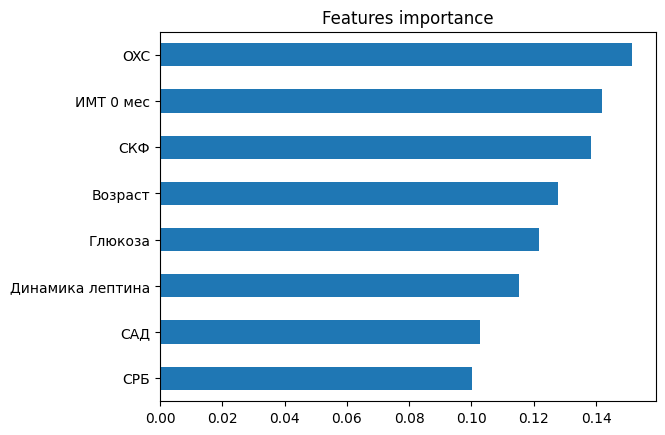

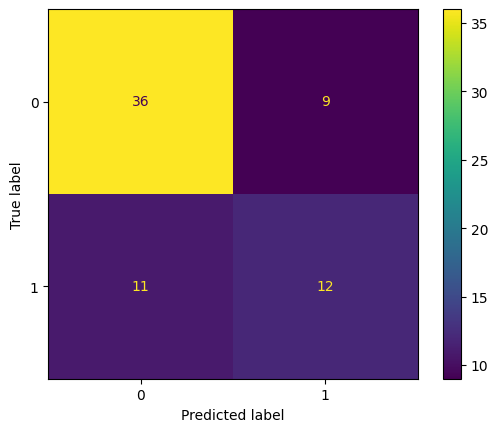

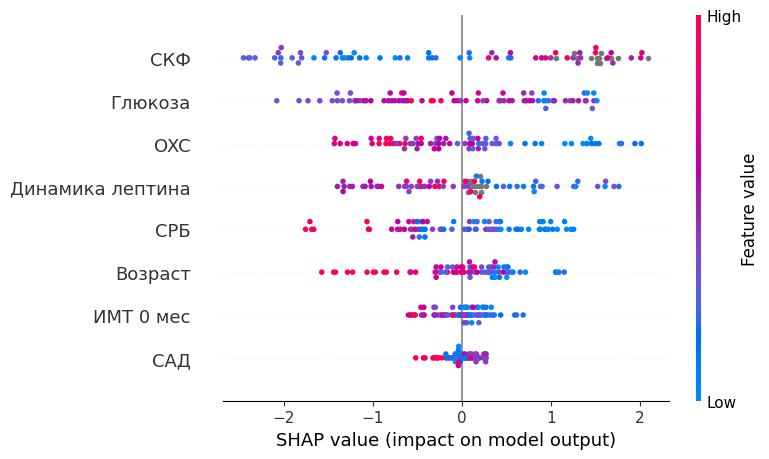

In [243]:
dt = Dataset(dataset_path="data/dataset.xlsx"); dt.preprocess(medicine="SIB")
# dt = Dataset(dataset_path="data/dataset_september.xlsx"); dt.preprocess(agroup_params_only=False)

# params_good =  [ "ИМТ 3 мес", "СРБ", "Лептинрезистентность", "Глюкоза", 'СКФ', "САД", "% потери веса 3 мес"]
params_good = ['Возраст', 'ИМТ 0 мес', 'СРБ', 'Глюкоза', 'СКФ', 'OXC', 'САД', 'Динамика лептина']
# params_good = ['ИМТ 0 мес']
# params_good = ['Вес 0 мес', 'OXC', 'Возраст']

# params_good.extend(['ГПП 1 нг/мл 0 мес', 'ГИП (пг/мл) 0 мес', 'miR142 (ПЛАЗМА) 0 мес'])
# params_good.extend(['ГПП 1 нг/мл 0 мес', 'ГИП (пг/мл) 0 мес', 'Грелин (нг/мл) 0 мес', 'miR142 (ПЛАЗМА) 0 мес', 'Проколлаген 1 типа нг/мл (183-244) 0 мес', 'Проколлаген 3 типа пг/мл (11178-36957) 0 мес', 'sST2 нг/мл (15,15-26,86) 0 мес' ])
# params_good.extend(['EQ-5'])

# X, y = dt.get_X_y("SIB", 7, params=params_good, target_type="both")
X, y = dt.get_X_y("SIB", 5, params=params_good, target_type="A")
model = XGBClassifier()
model, X, y_true, y_pred, y_pred_proba = classification_experiment(model, X, y, use_pipeline=False)
experiment_logger(model, X, y_true, y_pred, y_pred_proba)

,Возраст,ИМТ 0 мес,Динамика лептина,СРБ,Глюкоза,СКФ,OXC,САД,ГПП 1 нг/мл 0 мес,ГИП (пг/мл) 0 мес,Грелин (нг/мл) 0 мес,miR142 (ПЛАЗМА) 0 мес,"sST2 нг/мл (15,15-26,86) 0 мес",y
1,-0.3505,-0.2344,0.1740,0.0076,0.0809,1.0386,-0.5015,0.0174,1.9648,0.8223,0.5520,0.6457,0.2173,0
8,-0.2803,0.1056,-0.1124,0.0397,1.0198,1.4654,-0.3179,0.1136,-0.6350,0.8157,1.0068,0.4738,0.0138,0
11,0.7612,0.0900,-0.1344,-0.0060,-0.2525,1.1033,0.4729,-0.0977,0.0489,-0.2663,0.3957,0.9717,0.2892,0
15,0.9153,0.1631,-0.0143,0.9673,0.9127,-0.3620,-0.2249,-0.0052,0.4053,-0.0940,0.5093,-0.0661,0.1409,0
22,0.4883,-0.2317,-0.0601,0.3491,-0.2294,-1.2763,0.4660,-0.0069,-1.4776,0.4042,0.4712,0.2496,-0.0295,1
37,1.1441,0.1910,0.0196,0.9905,-0.0869,-0.6573,0.5911,-0.0977,0.3210,0.3814,0.6695,-0.3806,0.0483,0
39,0.4041,0.0406,0.1090,-0.5078,0.0154,0.9277,-0.9396,0.1379,1.6478,-0.2786,-0.7175,-0.6332,0.0753,1
40,0.5790,0.4329,0.1854,-0.4057,-0.0084,-0.5807,-0.2552,-0.1417,1.9941,0.5094,1.0043,0.8826,-0.8646,0
41,-1.1573,-0.0735,0.1476,-0.1421,-0.0024,-1.1992,-0.1828,-0.1417,2.1148,-0.3726,0.4434,-0.8834,0.0755,1
42,-0.3263,0.4329,0.1635,-0.0762,-0.1259,-0.7148,-0.0882,0.1198,2.5038,-0.1465,1.5740,-0.0598,0.1358,0


,Возраст,ИМТ 0 мес,Динамика лептина,СРБ,Глюкоза,СКФ,OXC,САД,ГПП 1 нг/мл 0 мес,ГИП (пг/мл) 0 мес,Грелин (нг/мл) 0 мес,miR142 (ПЛАЗМА) 0 мес,"sST2 нг/мл (15,15-26,86) 0 мес",y
1,44.0000,33.1000,-41.7283,3.6300,5.3000,108.5500,6.1900,110.0000,2.4100,137.1700,3.7100,NaN,10.4200,1
8,47.0000,35.5000,3.8176,2.1700,4.3500,111.7000,7.1500,120.0000,4.6300,147.4500,4.9400,"160,774.4063",NaN,1
11,34.0000,34.8000,26.1887,6.0300,5.6900,121.8900,4.6900,130.0000,5.2300,304.6800,3.7500,NaN,17.6800,1
15,28.0000,30.7000,-8.7391,0.5300,4.1300,90.4200,5.4900,100.0000,5.1300,400.2700,0.8800,"38,088.8000",23.3500,1
22,32.0000,34.6800,-11.7687,1.0600,5.0800,67.8500,3.6100,110.0000,4.0000,94.5000,10.4600,"163,016.8800",11.4000,0
37,29.0000,32.4500,-6.2257,1.1900,5.4200,77.8000,4.6800,130.0000,5.6000,82.2800,1.0600,"17,111.7400",NaN,1
39,24.0000,31.6700,-24.5924,10.4800,5.2300,125.3400,5.9900,120.0000,2.7600,385.8300,2.7600,"9,190.1000",NaN,0
40,25.0000,47.4600,-17.2169,16.8700,4.8500,89.6600,5.6500,130.0000,2.8000,45.3000,4.0700,NaN,1.1600,1
41,51.0000,39.0300,-14.1561,3.1600,5.3900,94.3900,5.4100,140.0000,2.5200,225.0000,4.1000,"24,640.4985",NaN,0
42,50.0000,40.4500,-12.1397,3.5100,5.7500,75.5000,4.8700,120.0000,2.3000,218.9000,11.2700,"26,755.5500",11.2500,1




              precision    recall  f1-score   support

           0       0.80      0.93      0.86        46
           1       0.80      0.52      0.63        23

    accuracy                           0.80        69
   macro avg       0.80      0.73      0.75        69
weighted avg       0.80      0.80      0.78        69



ROC AUC score:  0.782608695652174


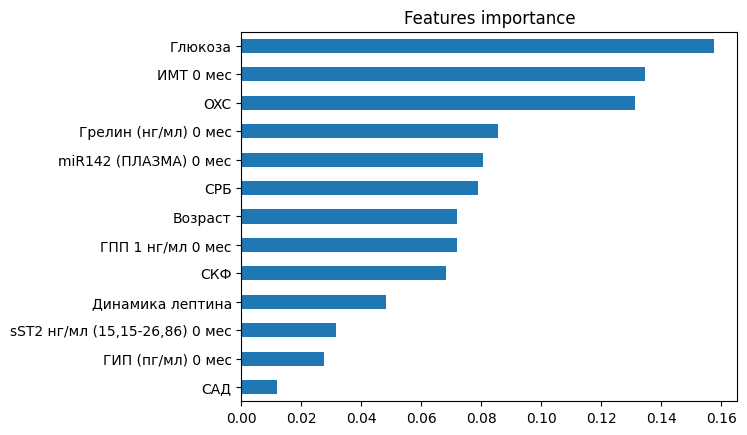

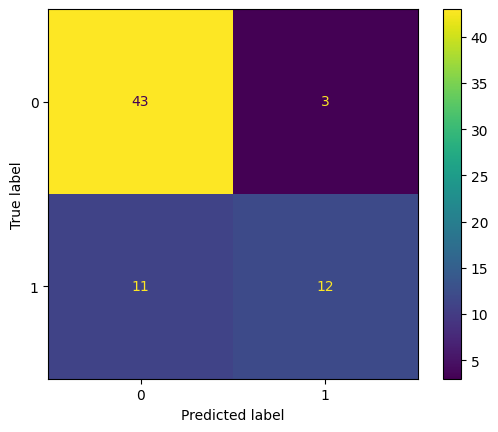

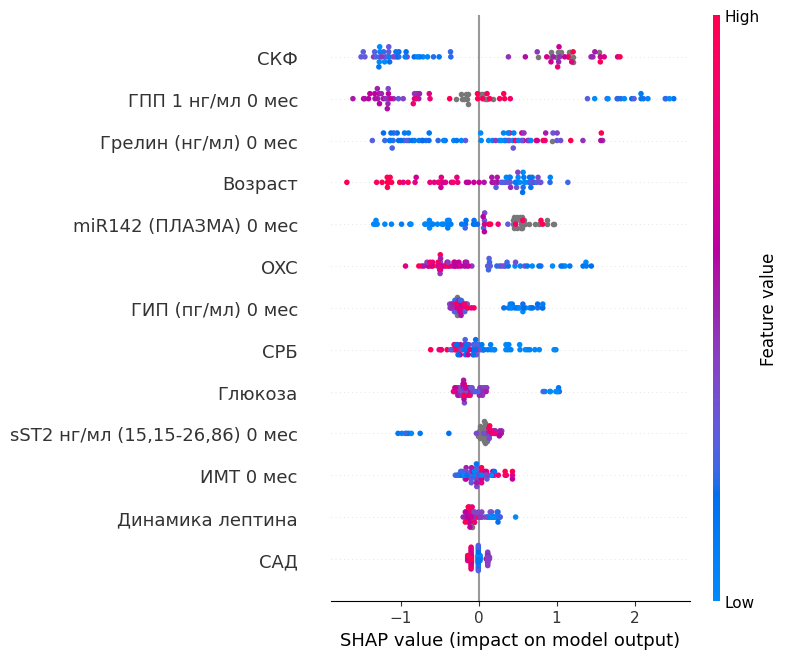

In [252]:
params_good = ['Возраст', 'ИМТ 0 мес', "Динамика лептина", 'СРБ', 'Глюкоза', 'СКФ', 'OXC', 'САД', 'ГПП 1 нг/мл 0 мес', 'ГИП (пг/мл) 0 мес', 'Грелин (нг/мл) 0 мес', 'miR142 (ПЛАЗМА) 0 мес',  'sST2 нг/мл (15,15-26,86) 0 мес']
X, y = dt.get_X_y("SIB", 5, params=params_good, target_type="A")
model = XGBClassifier()
model, X, y_true, y_pred, y_pred_proba = classification_experiment(model, X, y, use_pipeline=False)
experiment_logger(model, X, y_true, y_pred, y_pred_proba)

,ИМТ 3 мес,СРБ,Динамика лептина,Глюкоза,СКФ,САД,% потери веса 3 мес,y
4,0.8172,-0.6826,0.1675,0.3992,0.0863,0.6186,-0.1912,0
19,0.2771,-0.7085,-0.0653,0.2557,-0.0242,0.4831,-2.2402,1
20,0.9817,-0.5856,2.7511,0.5204,0.1200,-1.5467,-0.7956,0
22,-0.7087,-0.7255,0.5001,0.3033,-0.0242,-1.8269,-0.3968,1
23,-0.7970,-0.7929,0.2369,-0.6643,-0.4253,0.5294,-0.3936,1
28,0.4192,-0.6684,-2.4455,-0.6643,0.1016,0.5230,-0.4991,1
30,0.7190,1.4688,0.7663,-0.3692,0.0357,0.8462,-1.7957,0
34,0.1024,1.4173,-1.6402,0.4684,0.1211,-1.8148,1.2295,0
36,-0.4434,1.0114,-2.2473,0.2386,0.1211,0.5030,1.9567,0
41,-0.4490,1.2367,-2.2078,0.1428,0.1211,-1.8604,0.9484,1


,ИМТ 3 мес,СРБ,Динамика лептина,Глюкоза,СКФ,САД,% потери веса 3 мес,y
4,34.8300,3.9500,7.0122,4.0800,84.1800,120.0000,4.0000,1
19,30.5000,2.2800,-4.3233,5.1500,88.9100,120.0000,3.4091,0
20,32.0300,14.3000,-33.3289,5.1600,112.0300,130.0000,3.5294,1
22,44.7000,16.8700,-17.2169,4.8500,89.6600,130.0000,5.8333,0
23,38.0500,3.5100,-12.1397,5.7500,75.5000,120.0000,5.9406,0
28,32.2400,4.3600,15.4079,5.3600,131.1100,120.0000,5.2083,0
30,32.0400,1.2900,-9.5808,6.9800,82.6200,110.0000,2.4390,1
34,38.8900,1.7700,NaN,5.2400,NaN,139.0000,6.1947,1
36,31.1200,1.2900,NaN,4.3300,NaN,123.0000,7.1429,1
41,28.0100,0.9300,NaN,4.8000,NaN,129.0000,6.9767,0




              precision    recall  f1-score   support

           0       0.77      0.77      0.77        22
           1       0.77      0.77      0.77        22

    accuracy                           0.77        44
   macro avg       0.77      0.77      0.77        44
weighted avg       0.77      0.77      0.77        44



ROC AUC score:  0.8574380165289256


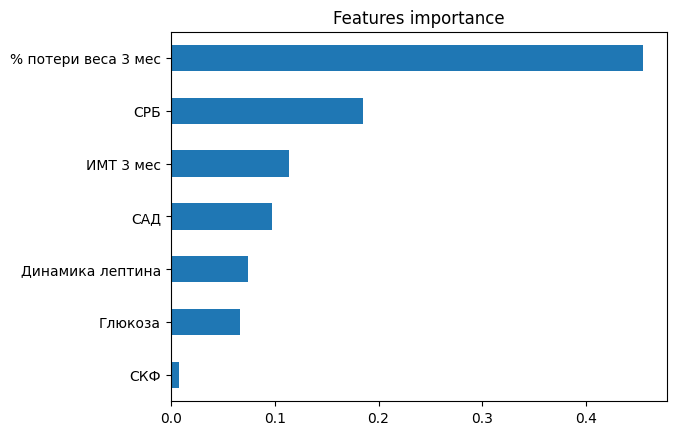

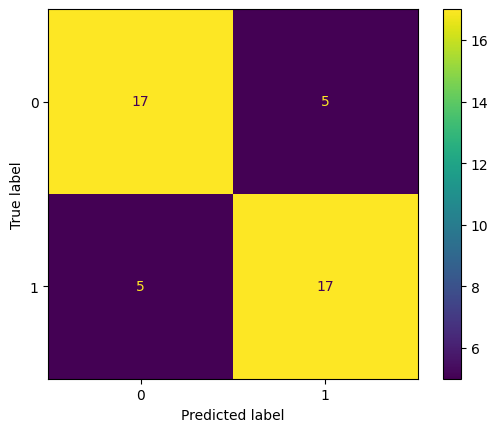

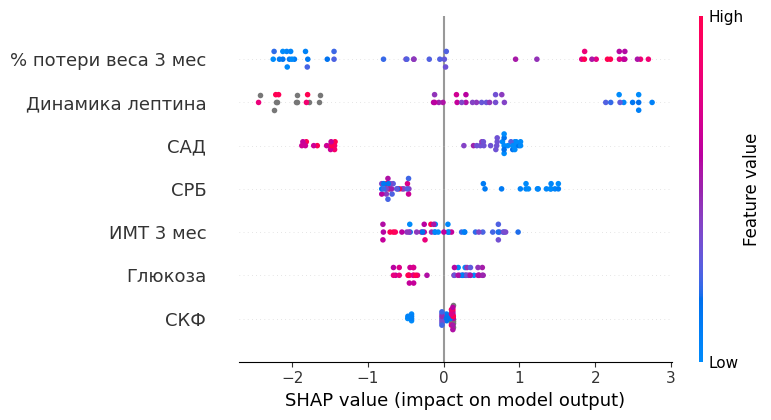

In [247]:
params_good =  [ "ИМТ 3 мес", "СРБ", "Динамика лептина", "Глюкоза", 'СКФ', "САД", "% потери веса 3 мес"]
# params_good =  [ "ИМТ 3 мес",  "% потери веса 3 мес"]
X, y = dt.get_X_y("SIB", 7, params=params_good, target_type="both")
model = XGBClassifier() 
model, X, y_true, y_pred, y_pred_proba = classification_experiment(model, X, y, use_pipeline=False)
experiment_logger(model, X, y_true, y_pred, y_pred_proba)

,ИМТ 3 мес,СРБ,Динамика лептина,САД,% потери веса 3 мес,ГПП 1 нг/мл 0 мес,ГИП (пг/мл) 0 мес,Грелин (нг/мл) 0 мес,miR142 (ПЛАЗМА) 0 мес,"sST2 нг/мл (15,15-26,86) 0 мес",y
20,0.6409,-0.3847,0.7060,-0.8074,-0.8498,0.3307,-0.2188,1.3203,0.1390,0.1025,0
23,-0.5890,-0.5785,0.1432,0.4924,-0.5029,-0.3771,-0.2404,-0.3471,-0.2468,-0.0481,1
30,0.6409,1.2873,0.2193,0.4290,-1.3178,-0.3771,0.5184,-0.2276,0.2678,-0.0209,0
34,-0.5890,1.1279,-0.5683,-1.3346,0.7864,0.1572,-0.3795,-0.5341,0.1619,-0.0209,0
41,0.5117,0.6289,-0.5683,-1.3346,0.6961,0.2292,-0.3795,-0.5960,0.1979,-0.0209,1


,ИМТ 3 мес,СРБ,Динамика лептина,САД,% потери веса 3 мес,ГПП 1 нг/мл 0 мес,ГИП (пг/мл) 0 мес,Грелин (нг/мл) 0 мес,miR142 (ПЛАЗМА) 0 мес,"sST2 нг/мл (15,15-26,86) 0 мес",y
20,32.0300,14.3000,-33.3289,130.0000,3.5294,3.9000,604.7000,0.7900,"19,999.4400",4.6500,1
23,38.0500,3.5100,-12.1397,120.0000,5.9406,2.3000,218.9000,11.2700,"26,755.5500",11.2500,0
30,32.0400,1.2900,-9.5808,110.0000,2.4390,3.2000,124.1000,8.7000,"34,237.7700",NaN,1
34,38.8900,1.7700,NaN,139.0000,6.1947,NaN,NaN,NaN,NaN,NaN,1
41,28.0100,0.9300,NaN,129.0000,6.9767,NaN,NaN,4.4400,NaN,NaN,0




              precision    recall  f1-score   support

           0       0.87      0.91      0.89        22
           1       0.90      0.86      0.88        22

    accuracy                           0.89        44
   macro avg       0.89      0.89      0.89        44
weighted avg       0.89      0.89      0.89        44



ROC AUC score:  0.9008264462809917


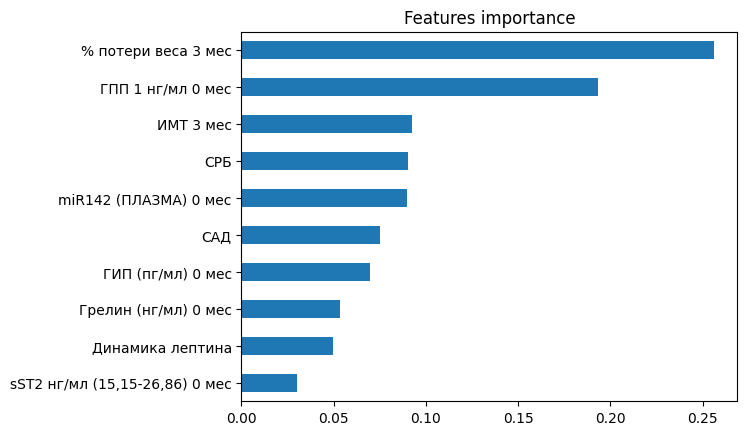

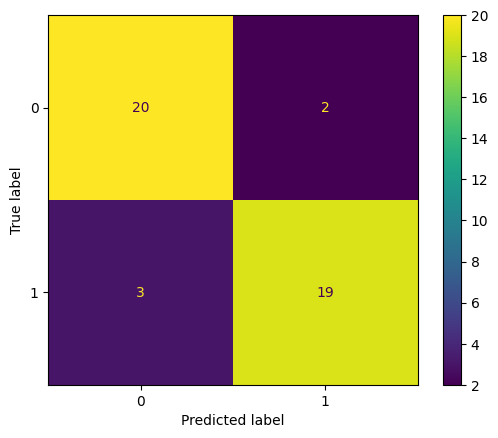

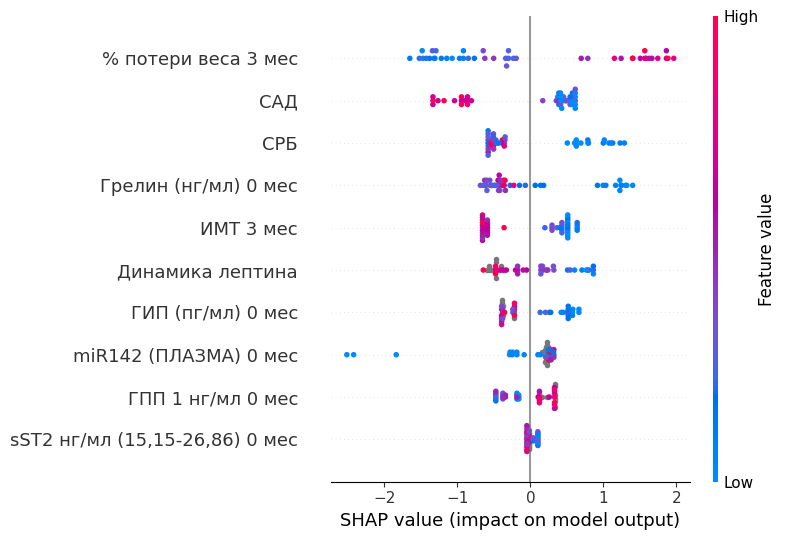

In [249]:
params_good = [ "ИМТ 3 мес", "СРБ", "Динамика лептина", "САД", "% потери веса 3 мес", 'ГПП 1 нг/мл 0 мес', 'ГИП (пг/мл) 0 мес', 'Грелин (нг/мл) 0 мес', 'miR142 (ПЛАЗМА) 0 мес', 'sST2 нг/мл (15,15-26,86) 0 мес'])
X, y = dt.get_X_y("SIB", 7, params=params_good, target_type="both")
model = XGBClassifier()
model, X, y_true, y_pred, y_pred_proba = classification_experiment(model, X, y, use_pipeline=False)
experiment_logger(model, X, y_true, y_pred, y_pred_proba)

In [47]:
dt.dataset[np.abs(dt.dataset["% потери веса 3 мес"]-5) < 0.3]

,% потери веса 3 мес,% потери веса 6 мес,Пол,Возраст,Рост,Вес 0 мес,Вес 3 мес,Вес 6 мес,ОТ 0 мес,ОТ 3 мес,...,Голод,Сытость,Степень желания поесть,Сколько может сьесть,Никотин В1.,Алкоголь В1.,EQ-5,Депрессия,Тревога,Динамика лептина
24,4.7619,7.6190,1,32,174,105.0000,100.0000,97.0000,114,108.0000,...,7.0000,3.0000,7.0000,5.0000,0.0000,1.0000,80.0000,2.0000,6.0000,-11.7687
55,5.2083,6.2500,1,47,168,96.0000,91.0000,90.0000,107,101.0000,...,4.0000,4.0000,4.0000,4.0000,0.0000,9.0000,80.0000,3.0000,11.0000,15.4079


In [20]:
def plot_data(arrp=["% потери веса 6 мес", "% потери веса 3 мес", "Лептинрезистентность"]):
    global dt
    df = dt.dataset
    plt.scatter(df[arrp[0]], df[arrp[1]], c = df[arrp[2]] if len(arrp)>2 else None, cmap="plasma")
    plt.xlabel(arrp[0])
    plt.ylabel(arrp[1])
    plt.title(f"Зависимость переменных - {arrp}")


In [54]:
dt.dataset["СДАД"] = (1/3)*dt.dataset["САД"]+(2/3)*dt.dataset["ДАД"]

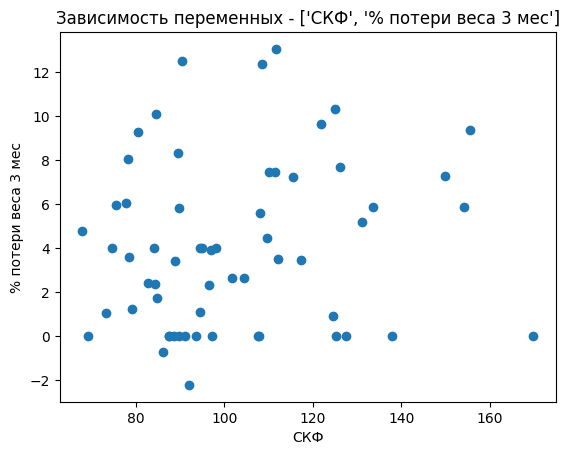

In [84]:
p = [
    # "ИМТ 0 мес",
    # "Рост",
    # "Вес 0 мес",
    # "ДАД",
    # "САД",
    # "СДАД",
    "СКФ",
    # "Возраст"
]
z = [
    "% потери веса 3 мес",
    # "ИМТ 0 мес",
    # "Рост",
    # "Вес 0 мес",
    # "ДАД",
    # "САД",
    # "СДАД",
    # "СКФ",
    # "Возраст"
]
plot_data([p[0], z[0]])

In [83]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


You should consider upgrading via the 'D:\covid\endocryn\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [ ]:
!pip install seaborn
import seaborn as sns

In [89]:
 df = dt.dataset.copy()
p = [df[(df["Лечение"] == "SIB") & (df["% потери веса 3 мес"] < 5)][param].reset_index(drop=True),
 df[(df["Лечение"] == "SIB") & (df["% потери веса 3 мес"] >= 5)][param].reset_index(drop=True)]
f = pd.concat(p, axis=1, ignore_index=True)
f

,0,1
0,1.0400,2.8700
1,6.2400,2.4100
2,3.2200,3.6600
3,3.5900,4.6300
4,3.4900,5.2300
5,5.6000,3.6900
6,4.9000,5.1300
7,4.3300,5.4100
8,4.7000,4.1000
9,5.0700,5.6000


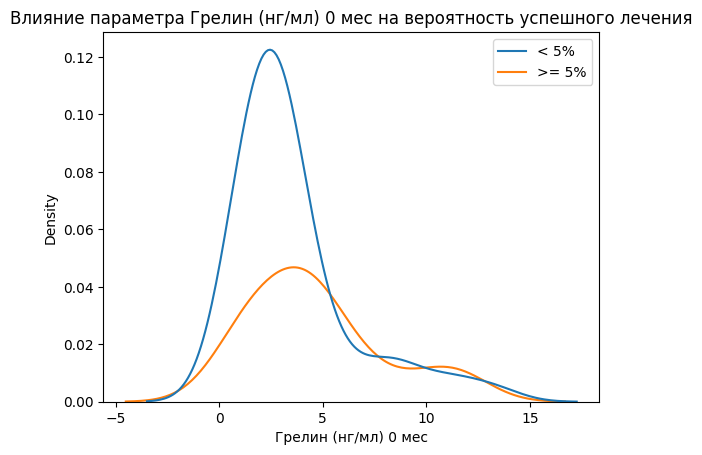

In [31]:
import seaborn as sns
def kde_plot(param):
    global dt
    df = dt.dataset.copy()
    p = [df[(df["Лечение"] == "SIB") & (df["% потери веса 3 мес"] < 5)][param].reset_index(drop=True),
         df[(df["Лечение"] == "SIB") & (df["% потери веса 3 мес"] >= 5)][param].reset_index(drop=True)]
    f = pd.concat(p, axis=1, ignore_index=True)
    f = f.rename(columns={0: "< 5%", 1: ">= 5%"})
    sns.kdeplot(f)
    plt.xlabel(param)
    plt.title(f"Влияние параметра {param} на вероятность успешного лечения")
param = 'Грелин (нг/мл) 0 мес'
kde_plot(param)

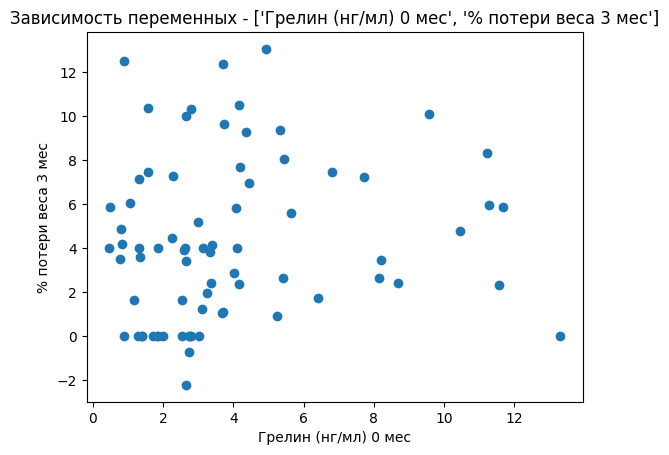

In [34]:
plot_data([param, "% потери веса 3 мес"])

Text(0, 0.5, 'Грелин (нг/мл) 0 мес')

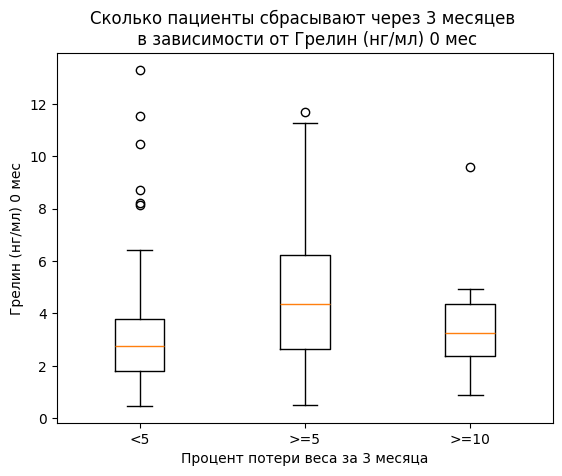

In [39]:
arrp=[param, "% потери веса 3 мес"]
df = dt.dataset.copy()
df = df[df["Лечение"] == "SIB"]
for i in arrp:
    df = df.loc[~pd.isna(df[i])]
# df[arrp[0]], df[arrp[1]], c = df[arrp[2]] if len(arrp)>2 else None
df["wlstep"] = (df[arrp[1]]/5).astype(int)
tmpdt = []
for i in range(0, 3):
    tmpdt.append(df[df["wlstep"]==i][arrp[0]])
plt.boxplot(tmpdt)
plt.xticks(ticks=[1, 2, 3],
           labels=["<5", ">=5", ">=10"])
plt.title(f"Сколько пациенты сбрасывают через 3 месяцев \n в зависимости от {param}")
plt.xlabel("Процент потери веса за 3 месяца")
plt.ylabel(param)
# plt.boxplot(df[arrp[0]].groupby((df[arrp[0]]/5).astype(int)))

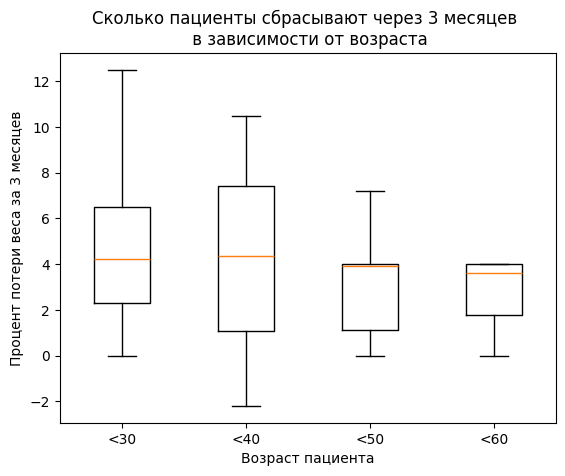

In [72]:
arrp=["% потери веса 3 мес", "Возраст"]
df = dt.dataset.copy()
df = df[df["Лечение"] == "SIB"]
for i in arrp:
    df = df.loc[~pd.isna(df[i])]
# df[arrp[0]], df[arrp[1]], c = df[arrp[2]] if len(arrp)>2 else None
df["wlstep"] = (df[arrp[1]]/10).astype(int)
tmpdt = []
for i in range(2, 6):
    tmpdt.append(df[df["wlstep"]==i][arrp[0]])
plt.boxplot(tmpdt)
plt.xticks(ticks=[1, 2, 3, 4],
           labels=["<30", "<40", "<50", "<60"])
plt.title("Сколько пациенты сбрасывают через 3 месяцев \n в зависимости от возраста")
plt.xlabel("Возраст пациента")
plt.ylabel("Процент потери веса за 3 месяцев")
plt.savefig("Зависимость потери веса за 3 месяца от Возраста.jpg")
# plt.boxplot(df[arrp[0]].groupby((df[arrp[0]]/5).astype(int)))

['Возраст', 'ИМТ 0 мес', 'СРБ', 'Глюкоза', 'СКФ', 'OXC', 'САД', 'Динамика лептина']


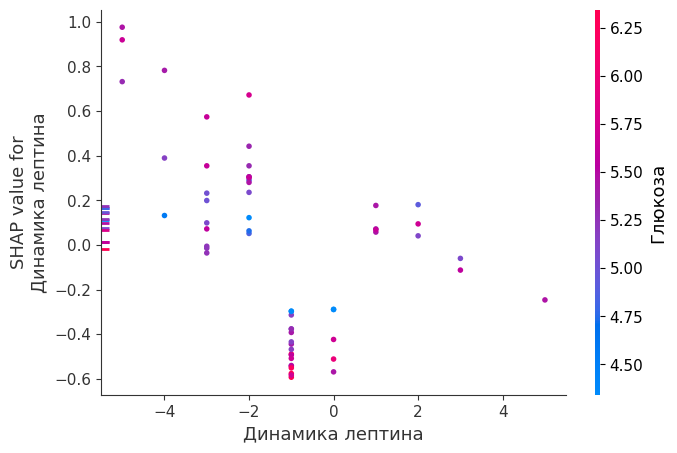

In [141]:
print(params_good)
exp = get_shap_explainer(model, X)
shap.dependence_plot(
    # "Вес 0 мес",
    "Динамика лептина",
    # "ГПП 1 нг/мл 0 мес",
    exp.shap_values_calculated,
    exp.X,
    # interaction_index="Лептинрезистентность",
    show=False
)
# plt.title("Как влияет % потери веса на прогноз модели о дальнейшем лечении")
# plt.xlabel("% потери веса 3 мес")
# plt.ylabel("Числа Шаплей \n для % потери веса 3 мес")
plt.show()

In [283]:
X.corr()

,Возраст,ДАД,OXC,СКФ,Глюкоза,ИМТ 0 мес,Лептинрезистентность,СРБ
Возраст,1.0000,-0.1689,0.2614,-0.3784,0.2351,-0.1547,0.2870,-0.3129
ДАД,-0.1689,1.0000,0.0159,0.0942,0.2086,0.2087,-0.0913,0.2947
OXC,0.2614,0.0159,1.0000,-0.3197,-0.0753,-0.0759,0.0948,0.0911
СКФ,-0.3784,0.0942,-0.3197,1.0000,0.0030,0.2077,-0.2204,0.2443
Глюкоза,0.2351,0.2086,-0.0753,0.0030,1.0000,0.0535,0.1358,-0.0098
ИМТ 0 мес,-0.1547,0.2087,-0.0759,0.2077,0.0535,1.0000,-0.1063,0.4739
Лептинрезистентность,0.2870,-0.0913,0.0948,-0.2204,0.1358,-0.1063,1.0000,-0.2628
СРБ,-0.3129,0.2947,0.0911,0.2443,-0.0098,0.4739,-0.2628,1.0000


In [139]:
dt_test = Dataset(dataset_path="data/dataset_almazov_november_test.xlsx"); dt.preprocess(agroup_params_only=True)
dt = Dataset(dataset_path="data/dataset_september.xlsx"); dt.preprocess(agroup_params_only=True)

params_good = ["ИМТ 3 мес", "СРБ", "Лептинрезистентность", "Глюкоза", 'СКФ', "ДАД"]
X, y  = dt.get_X_y("SIB", 7, params=params_good, target_type="both")
X_test, y_test = dt.get_X_y("SIB", 7, params=params_good, target_type="both")
model = XGBClassifier()
model.fit(X, y)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
get_predictions_with_confidence(model, X_test, y_test, False)

KeyError: "['ID', 'Пол 0 - М, 1 - Ж', 'Индекс Висцерального Ожирения (ИВО) 0 мес: [ОТ/(39,68+(1,88×ИМТ))×(ТГ/1,03)×(1,31/ЛВП)] — для мужчин, [ОТ/(36,58+(1,89×ИМТ))×(ТГ/0,81)×(1,52/ЛВП)] — для женщин', 'накопление липидных продуктов LAP=(ОТ (см)–65)×ТГ 0 мес', '(ОТ (см) к росту (см2))*1000 (ООТР) 0 мес', 'индекс конусности ИК= ОТ(м)/0,109×√(рост(м)/вес (кг) 0 мес', 'Степень Ожир', 'НТГ (нарушнгин толерантности к глюкозе)', 'Фенотип ожирения - 0 - Центральное ожирение, 1 - Периферическое ожирение, более 0,9 у мужчин и 0,85 у женщин – центральное ожиренрие, менее периферическое', 'Стаж ожирения (1 - до 5 лет, 2 5-10 лет, 3 - более 10 лет', 'Концентрическая гипертрофия 0- нет 1 - есть', 'Уровень NT-proBMP - 0 - Менее 125, 1 - более 120', 'Кардиогруппа 0 - стадия А (норма), 1 - ОЛП/рост2 повышен, 2 - ММЛЖ/рост2,7 повышен, 3 - ОЛП и ММЛЖ повышены', 'Лептинрезистентность 0 - повышение лептина, 1 - снижение лептина, 2 - лептин не изменялся', 'Тип ПП 0 - нет нарушений, 1 - эмоциогенное, 2 - экстернальное, 3 - ограничительное', 'Глюкоза крови натощак ммоль/л (3,3-6,1) 0 мес', 'Инсулин пкмоль/л (17.80 - 173.00) перемножить 6,945 0 мес', 'Индекс HOMA-IR (> 3) 0 мес', 'Индекс HOMA-В (20×инсулин плазмы натощак (мкЕд/мл)/глюкозы плазмы натощак (ммоль/л)-3,5 ) 0 мес', 'ОХС ммоль/л (3,5-5,0) 0 мес', 'ЛПВП ммоль/л (Ж >1.20, М>1.0) 0 мес', 'ЛПНП ммоль/л (<3.00) 0 мес', 'ТГ ммоль/л (<1.77) 0 мес', 'КА (0-3,5) 0 мес', 'Креатинин мкмоль/л (53-106) 0 мес', 'СКФ мл/мин/1.73м2 (> 60) 0 мес', 'Мочевая кислота ммоль/л (0.14 - 0.34) 0 мес', 'С-РБ мг/л (0-6) 0 мес', 'Эмоциональное пищевое поведение В1.', 'Экстернальное пищевое поведение В1.', 'Ограничительное (Диетическое) пищевое поведение В1.', 'Насколько голодным вы себя чувствуете? В1.', 'Насколько сытым вы себя чувствуете? В1.', 'Насколько сильно вы хотите есть? В1.', 'Сколько пищи вы могли бы сейчас съесть? В1.', 'EQ-5 В1.', 'Депрессия В1.', 'Тревога В1.'] not in index"

In [129]:
# c = "ГИП (пг/мл) 0 мес"
c = "ГПП 1 нг/мл 0 мес"
p = "Лептин (нг/мл) 0 мес"
q = "Лептин 1 час (нг/мл) 0 мес"
f = dt.dataset.copy()
f = f[~pd.isna(f[c]) & ~pd.isna(f[p]) & ~pd.isna(f[q])]
x = f[p] - f[q]
y = f[c]
pearsonr(x, y)

PearsonRResult(statistic=-0.2552618172475684, pvalue=0.024100732661805305)

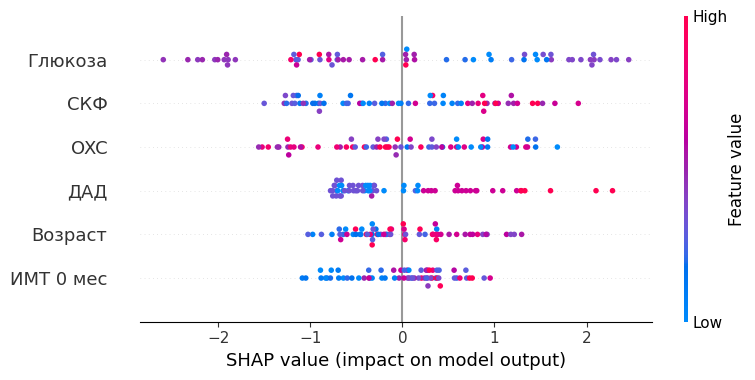

In [142]:
from datetime import datetime

def save_experiment(model, X, y, experiment_name, snapshot_folder = "model_snapshots"):
    current_datetime = datetime.now()
    formatted_datetime = current_datetime.strftime("%d_%m_%H")
    os.mkdir(f"{snapshot_folder}/{experiment_name}_{formatted_datetime}")
    model_path = f"{snapshot_folder}/{experiment_name}_{formatted_datetime}/model.pkl"
    expaliner_path = f"{snapshot_folder}/{experiment_name}_{formatted_datetime}/explainer.pkl"
    plot_path = f"{snapshot_folder}/{experiment_name}_{formatted_datetime}/shap_overall.jpg"
    data_path = f"{snapshot_folder}/{experiment_name}_{formatted_datetime}/data.csv"

    model.fit(X, y)
    pickle.dump(model, open(model_path, "wb"))
    explainer = get_shap_explainer(model, X, y)
    pickle.dump(explainer, open(expaliner_path, "wb"))
    data = pd.concat([X, pd.Series(y)], axis=1).rename(columns={0: "success"})
    data.to_csv(data_path)

    shap.summary_plot(explainer.shap_values_calculated[:, :], X, show=False)
    plt.tight_layout()
    plt.savefig(plot_path)


save_experiment(model, X, "xgboost_agroup_leptinresistncy")

### 3 bins



              precision    recall  f1-score   support

           0       0.60      0.72      0.66        36
           1       0.35      0.30      0.32        20
           2       0.00      0.00      0.00         8

    accuracy                           0.50        64
   macro avg       0.32      0.34      0.33        64
weighted avg       0.45      0.50      0.47        64





,0,1
3,Лептин (нг/мл) 0 мес,0.2176
1,ДАД,0.2001
5,Глюкоза,0.1789
4,Креатинин,0.1771
0,OXC,0.1739
2,Возраст,0.0523


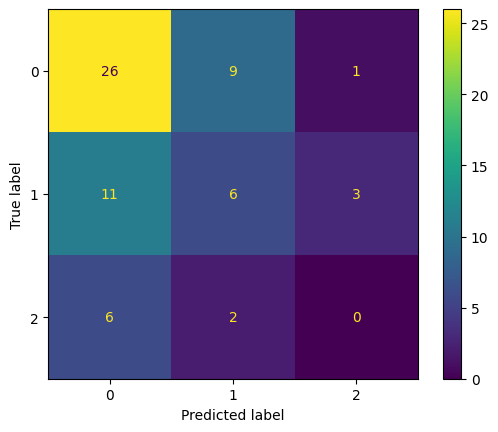

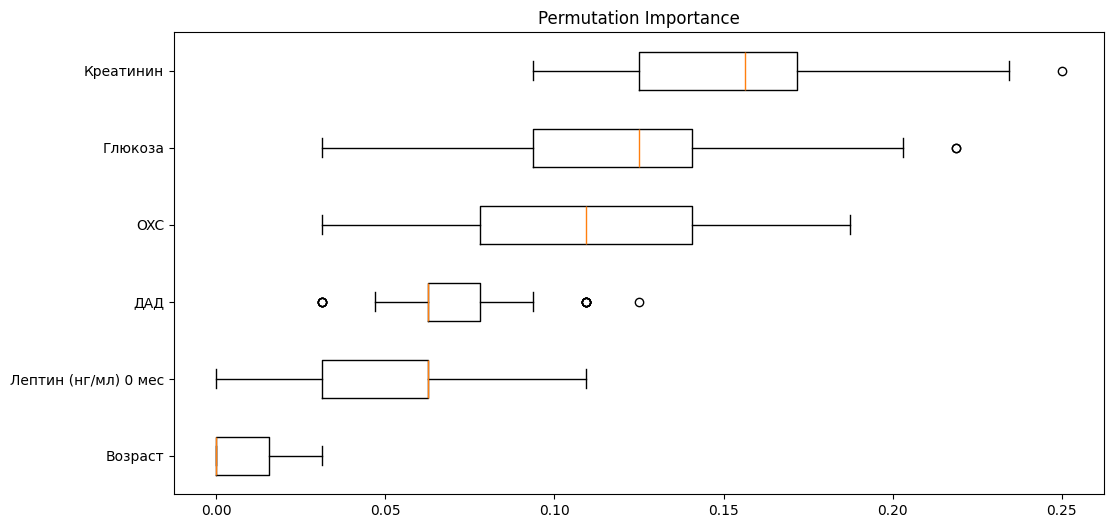

TypeError: only integer scalar arrays can be converted to a scalar index

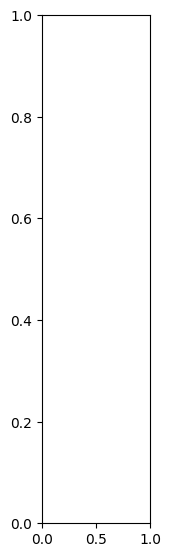

In [16]:
dt = Dataset(dataset_path="data/dataset_september.xlsx")
dt.preprocess(agroup_params_only=True)
params_good = ["OXC", "ДАД", "Возраст", "Лептин (нг/мл) 0 мес", "Креатинин", "Глюкоза"]
X, y = dt.get_X_y("SIB", [5, 10], params=params_good)
model, X, y_true, y_pred = classification_experiment(XGBClassifier(), X, y, use_pipeline=False)
experiment_logger(model, X, y_true, y_pred)



              precision    recall  f1-score   support

           0       0.65      0.80      0.71        44
           1       0.50      0.44      0.47        25
           2       0.33      0.10      0.15        10

    accuracy                           0.59        79
   macro avg       0.49      0.45      0.45        79
weighted avg       0.56      0.59      0.57        79





,0,1
1,ДАД,0.2387
0,OXC,0.1933
5,Глюкоза,0.1740
3,Лептин (нг/мл) 0 мес,0.1680
4,Креатинин,0.1177
2,Возраст,0.1083


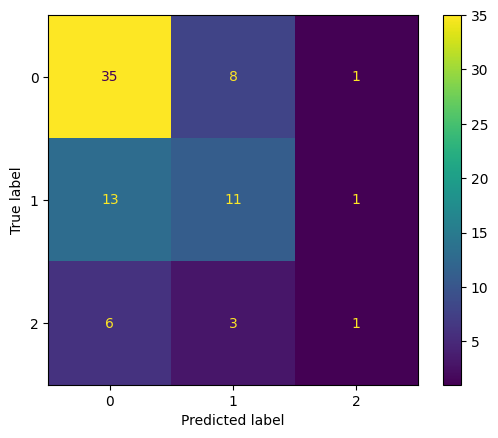

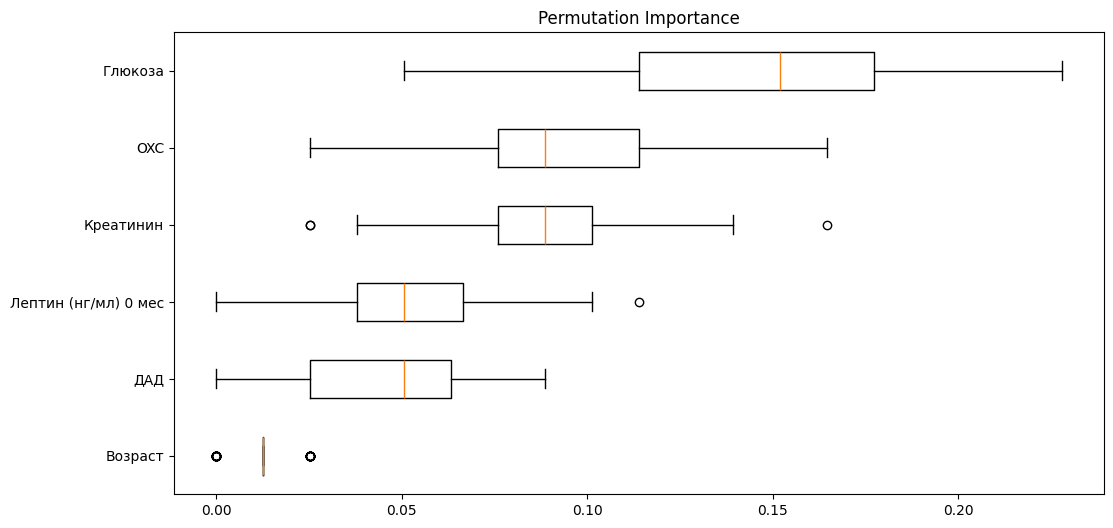

TypeError: only integer scalar arrays can be converted to a scalar index

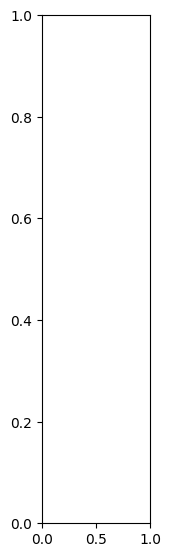

In [17]:
dt = Dataset(dataset_path="data/dataset_almazov_november.xlsx")
dt.preprocess(agroup_params_only=True)
params_good = ["OXC", "ДАД", "Возраст", "Лептин (нг/мл) 0 мес", "Креатинин", "Глюкоза"]
X, y = dt.get_X_y("SIB", [5, 10], params=params_good)
model, X, y_true, y_pred = classification_experiment(XGBClassifier(), X, y, use_pipeline=False)
experiment_logger(model, X, y_true, y_pred)

### scientific params



              precision    recall  f1-score   support

           0       0.55      0.52      0.53        33
           1       0.67      0.70      0.68        46

    accuracy                           0.62        79
   macro avg       0.61      0.61      0.61        79
weighted avg       0.62      0.62      0.62        79



ROC AUC score:  0.6185770750988143


,0,1
1,СРБ,0.2077
0,"параксоназа мкг/мл (0,56-8,2) 0 мес",0.1716
5,Инсулин,0.1602
4,Лептин 1 час (нг/мл) 0 мес,0.1565
3,miR142 (ПЛАЗМА) 0 мес,0.1523
2,Грелин 1 час (нг/мл) 0 мес,0.1515


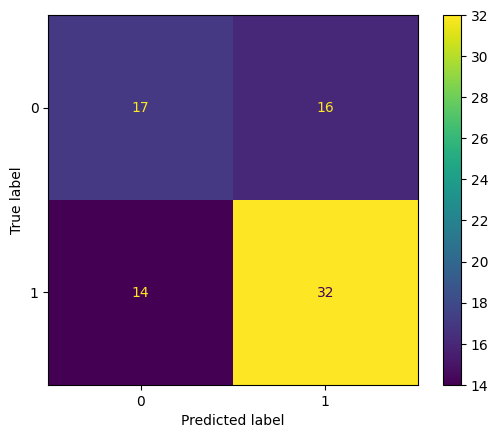

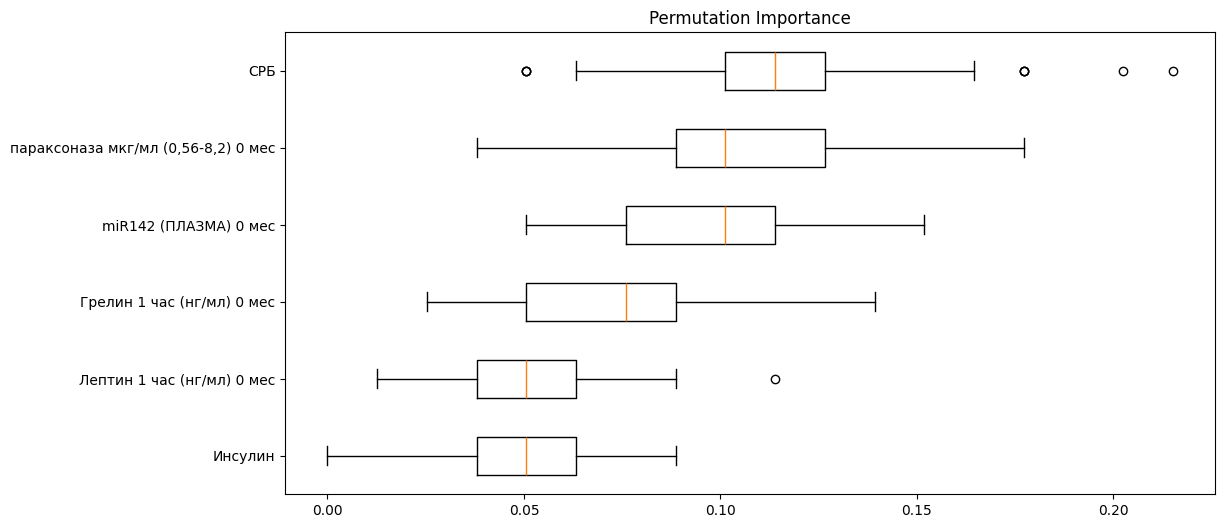

InvalidModelError: Model type not yet supported by TreeExplainer: <class 'sklearn.pipeline.Pipeline'>

In [181]:
dt = Dataset(dataset_path="data/dataset_almazov_november.xlsx")
dt.preprocess(agroup_params_only=False)
params_good = ['параксоназа мкг/мл (0,56-8,2) 0 мес',
                'СРБ',
                'Грелин 1 час (нг/мл) 0 мес',
                'miR142 (ПЛАЗМА) 0 мес',
                'Лептин 1 час (нг/мл) 0 мес',
                'Инсулин']
X, y = dt.get_X_y("SIB", 5, params=params_good, target_type="C")
model, X, y_true, y_pred, y_pred_proba = classification_experiment(RandomForestClassifier(), X, y, use_pipeline=True)
experiment_logger(model, X, y_true, y_pred, y_pred_proba)

In [162]:
model

Pipeline(steps=[('imputer', None), ('sclaer', None),
                ('model', RandomForestClassifier())])



              precision    recall  f1-score   support

           0       0.60      0.72      0.66        36
           1       0.35      0.30      0.32        20
           2       0.00      0.00      0.00         8

    accuracy                           0.50        64
   macro avg       0.32      0.34      0.33        64
weighted avg       0.45      0.50      0.47        64





,0,1
3,Лептин (нг/мл) 0 мес,0.2176
1,ДАД,0.2001
5,Глюкоза,0.1789
4,Креатинин,0.1771
0,OXC,0.1739
2,Возраст,0.0523


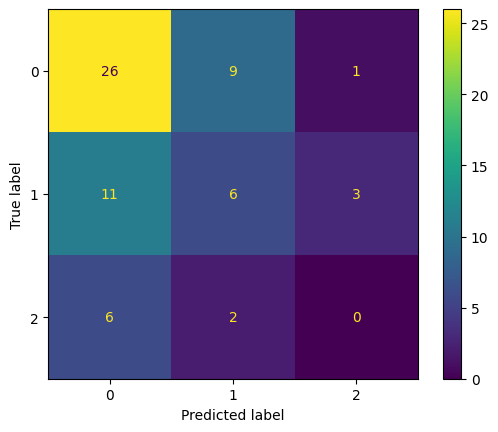

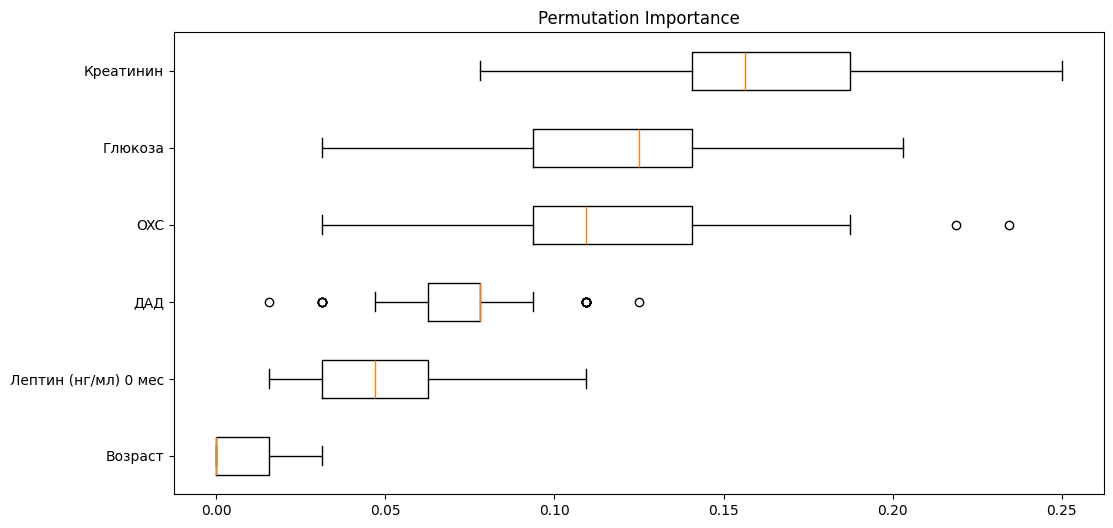

TypeError: only integer scalar arrays can be converted to a scalar index

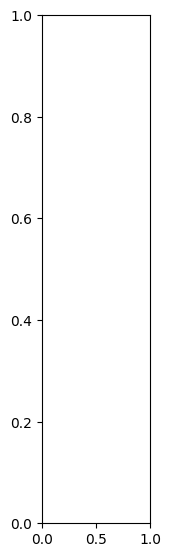

In [29]:
params_good = ["OXC", "ДАД", "Возраст", "Лептин (нг/мл) 0 мес", "Креатинин", "Глюкоза"]
X, y = dt.get_X_y("SIB", [5, 10], params=params_good)
model, X, y_true, y_pred = classification_experiment(XGBClassifier(), X, y, use_pipeline=False)
experiment_logger(model, X, y_true, y_pred)

In [30]:
print(classification_report(y_test, model.predict(X_test)))
get_predictions_with_confidence(model, X_test, y_test, True)

              precision    recall  f1-score   support

           0       0.67      0.67      0.67         9
           1       0.67      0.33      0.44         6
           2       0.00      0.00      0.00         0

    accuracy                           0.53        15
   macro avg       0.44      0.33      0.37        15
weighted avg       0.67      0.53      0.58        15



,Real,Predicted,Confidence
0,5% - 10%,less 5%,[0.76 0.22 0.02]
1,5% - 10%,less 5%,[0.96 0.02 0.02]
2,5% - 10%,5% - 10%,[0.02 0.94 0.04]
3,less 5%,less 5%,[0.6 0.36 0.04]
4,5% - 10%,more 10%,[0.08 0.28 0.64]
5,less 5%,5% - 10%,[0.31 0.4 0.29]
6,less 5%,more 10%,[0.14 0.23 0.63]
7,less 5%,less 5%,[0.97 0.01 0.02]
8,less 5%,less 5%,[0.83 0.03 0.14]
9,5% - 10%,less 5%,[0.9 0.09 0.01]


### Feature Elimination

In [4]:
def recursively_delete_params(model, dt, set_of_params):
  params_to_eliminate = set_of_params.copy()
  stats = []
  while len(params_to_eliminate)>=1:
    current_set_of_params = params_to_eliminate.copy()
    X, y = dt.get_X_y("SIB", 5, params=current_set_of_params, target_type="A")
    model, _, y_true, y_pred = classification_experiment(model, X, y, use_pipeline=False)
    statdf = pd.DataFrame(list(zip(current_set_of_params, model.feature_importances_))).sort_values(by=1, ascending=False)
    macro_f1 = classification_report(y_true, y_pred, output_dict=True)["macro avg"]["f1-score"]
    stats.append([current_set_of_params, macro_f1, len(current_set_of_params)])
    print("Progress: ", len(set_of_params) - len(current_set_of_params), " / ", len(set_of_params), "F1 score ", macro_f1)
    param_to_remove = statdf.iloc[-1, 0]
    params_to_eliminate.remove(param_to_remove)
  dfstats = pd.DataFrame(stats, columns=["Set of params", "F1", "Count of parameters"])
  dfstats = dfstats.sort_values(by = "F1", ascending=False)
  return dfstats

In [5]:
def recursively_delete_params_with_evaluation(model, dt, set_of_params):
  current_set_of_params = set_of_params.copy()
  stats = []
    
  def evaluate(model, dt, set_of_params):
    X, y = dt.get_X_y("SIB", 5, params=set_of_params, target_type="A")
    model, _, y_true, y_pred = classification_experiment(model, X, y, use_pipeline=False)
    macro_f1 = classification_report(y_true, y_pred, output_dict=True)["macro avg"]["f1-score"]
    return model, macro_f1
      
  def create_report(stats):
    dfstats = pd.DataFrame(stats, columns=["Set of params", "F1", "Count of parameters"])
    dfstats = dfstats.sort_values(by = "F1", ascending=False)
    return dfstats
      
  while len(current_set_of_params)>=1:
    model, macro_f1 = evaluate(model, dt, current_set_of_params)
    statdf = pd.DataFrame(list(zip(current_set_of_params, model.feature_importances_))).sort_values(by=1, ascending=False)
    for i in range(1, statdf.shape[0]-1):
        param_to_remove = statdf.iloc[-i, 0]
        tmp_set_params = current_set_of_params.copy()
        tmp_set_params.remove(param_to_remove)
        model, macro_f1_tmp = evaluate(model, dt, tmp_set_params)
        if (macro_f1_tmp >= macro_f1):
            macro_f1 = macro_f1_tmp
            current_set_of_params = tmp_set_params
            break
    else:
        print(f"Search ended. Number of parameters: { len(current_set_of_params) }. F1 = { macro_f1 }")
        stats.append([current_set_of_params, macro_f1, len(current_set_of_params)])
        return create_report(stats)
    stats.append([current_set_of_params, macro_f1, len(current_set_of_params)])
    print(f"Progress: {len(set_of_params) - len(current_set_of_params)} / {len(set_of_params)} :: F1 = {macro_f1}")
  return create_report(stats)

In [10]:
def recursively_add_params(model, dt, set_of_params, all_params):
  current_set_of_params = set_of_params.copy()
  stats = []
    
  def evaluate(model, dt, set_of_params):
    X, y = dt.get_X_y("SIB", 5, params=set_of_params, target_type="A")
    model, _, y_true, y_pred, y_pred_proba = classification_experiment(model, X, y, use_pipeline=False)
    macro_f1 = classification_report(y_true, y_pred, output_dict=True)["macro avg"]["f1-score"]
    return model, macro_f1
    
  def create_report(stats):
    dfstats = pd.DataFrame(stats, columns=["Set of params", "F1", "Count of parameters"])
    dfstats = dfstats.sort_values(by = "F1", ascending=False)
    return dfstats
      
  _, macro_f1 = evaluate(model, dt, current_set_of_params) 
  macro_f1_init = macro_f1
  print(f"Init: {len(set_of_params)} :: F1 = {macro_f1_init} ")
  while len(current_set_of_params)<len(all_params):
    new_params = list(set(all_params) - set(current_set_of_params))
    for i in range(1, len(new_params)):
        print(new_params[i])
        param_to_add = new_params[i]
        tmp_set_params = current_set_of_params.copy()
        tmp_set_params.append(param_to_add)
        model, macro_f1_tmp = evaluate(model, dt, tmp_set_params)
        if (macro_f1_tmp > macro_f1):
            macro_f1 = macro_f1_tmp
            current_set_of_params = tmp_set_params
            break
    else:
        print(f"Search ended. Number of parameters: { len(current_set_of_params) }. F1 = { macro_f1 }")
        stats.append([current_set_of_params, macro_f1, len(current_set_of_params)])
        return create_report(stats)
    stats.append([current_set_of_params, macro_f1, len(current_set_of_params)])
    print(f"Progress: {- len(set_of_params) + len(current_set_of_params)} added :: F1 = {macro_f1} (+{- macro_f1_init + macro_f1}) ")
  return create_report(stats)

In [13]:
dt = Dataset(dataset_path="data/dataset_september.xlsx")
dt.preprocess(agroup_params_only=False)
X, y = dt.get_X_y("SIB", 5, target_type="A")
p = ["Возраст", "ИМТ 0 мес", "СРБ", "Лептинрезистентность", "Глюкоза", 'СКФ', "ДАД", "OXC"]
model = XGBClassifier()
res = recursively_add_params(XGBClassifier(), dt, p, list(X.columns.values))

Init: 8 :: F1 = 0.6158536585365854 
Пол
ГПП-1 после нагрузки 0 - норма и выше, 1 снижение
sST2 нг/мл (15,15-26,86) 0 мес
EQ-5
Progress: 1 added :: F1 = 0.6646119361165592 (+0.04875827757997386) 
Пол
ГПП-1 после нагрузки 0 - норма и выше, 1 снижение
sST2 нг/мл (15,15-26,86) 0 мес
И-АПФ
ГПП 1 нг/мл 1 час 0 мес
Тип пищевого поведения
Leptin 0 мес
Диуретики
В-Блокаторы
miR142 (ПЖТ) 0 мес
ЛПВП
Рост
Progress: 2 added :: F1 = 0.6856984478935699 (+0.06984478935698457) 
Пол
ГПП-1 после нагрузки 0 - норма и выше, 1 снижение
sST2 нг/мл (15,15-26,86) 0 мес
И-АПФ
ГПП 1 нг/мл 1 час 0 мес
Тип пищевого поведения
Leptin 0 мес
Диуретики
В-Блокаторы
miR142 (ПЖТ) 0 мес
ЛПВП
miR155 0 мес
Уровень NT-proBMP
Progress: 3 added :: F1 = 0.7142857142857143 (+0.09843205574912894) 
Пол
ГПП-1 после нагрузки 0 - норма и выше, 1 снижение
sST2 нг/мл (15,15-26,86) 0 мес
И-АПФ
ГПП 1 нг/мл 1 час 0 мес
Тип пищевого поведения
Leptin 0 мес
Диуретики
В-Блокаторы
miR142 (ПЖТ) 0 мес
ЛПВП
miR155 0 мес
ADIPOQ 0 мес
ГПП 1 нг/мл 0 

In [14]:
res.to_csv("04_recursiveadd_74.csv")

In [15]:
res.iloc[0, 0]

['Возраст',
 'ИМТ 0 мес',
 'СРБ',
 'Лептинрезистентность',
 'Глюкоза',
 'СКФ',
 'ДАД',
 'OXC',
 'EQ-5',
 'Рост',
 'Уровень NT-proBMP',
 'ГПП 1 нг/мл 0 мес',
 'sST2 нг/мл (15,15-26,86) 0 мес',
 'Индекс конусности (ИК)',
 'Пульс']

In [197]:
dt = Dataset(dataset_path="data/dataset_september.xlsx")
dt.preprocess(agroup_params_only=True)
X, y = dt.get_X_y("SIB", 5, target_type="A")
model, X, y_true, y_pred = classification_experiment(XGBClassifier(), X, y, use_pipeline=False)
params_test = [
 'ИМТ 0 мес',
 'Накопление липидных продуктов (LAP)',
 'Артериальная гипертензия',
 'ДАД',
 'Пульс',
 'Глюкоза',
 'Инсулин',
 'OXC',
 'ЛПВП',
 'ТГ',
 'КА',
 'Креатинин',
 'СКФ',
 'Мочевая Кислота',
 'СРБ',
 'Лептин (нг/мл) 0 мес',
 'Лептин 1 час (нг/мл) 0 мес',
 'Адипонектин (мкг/мл) 0 мес',
 'Лептин/Адипонектин 0 мес',
 'Эмоциональное ПП',
 'Экстернальное ПП',
 'Диетическое ПП',
 'Голод',
 'EQ-5',
 'Тревога']
print(f"Base estimation F1 with {len(params_test)} parameters: ", classification_report(y_true, y_pred, output_dict=True)["macro avg"]["f1-score"])
res = recursively_delete_params_with_evaluation(XGBClassifier(), dt, params_test)

Base estimation F1 with 25 parameters:  0.4420512820512821
Progress: 1 / 25 :: F1 = 0.5465587044534412
Progress: 2 / 25 :: F1 = 0.5465587044534412
Progress: 3 / 25 :: F1 = 0.5652830188679245
Progress: 4 / 25 :: F1 = 0.5789473684210527
Progress: 5 / 25 :: F1 = 0.5974842767295597
Progress: 6 / 25 :: F1 = 0.6014943960149439
Progress: 7 / 25 :: F1 = 0.6190476190476191
Progress: 8 / 25 :: F1 = 0.6507936507936507
Search ended. Number of parameters: 17. F1 = 0.6507936507936507


In [199]:
p = res.iloc[0, 0]
p

['Накопление липидных продуктов (LAP)',
 'Артериальная гипертензия',
 'ДАД',
 'Пульс',
 'Глюкоза',
 'Инсулин',
 'OXC',
 'Креатинин',
 'СКФ',
 'Мочевая Кислота',
 'СРБ',
 'Лептин 1 час (нг/мл) 0 мес',
 'Лептин/Адипонектин 0 мес',
 'Экстернальное ПП',
 'Диетическое ПП',
 'EQ-5',
 'Тревога']



              precision    recall  f1-score   support

           0       0.69      0.69      0.69        36
           1       0.61      0.61      0.61        28

    accuracy                           0.66        64
   macro avg       0.65      0.65      0.65        64
weighted avg       0.66      0.66      0.66        64



ROC AUC score:  0.6507936507936508


,0,1
2,ДАД,0.1793
1,Артериальная гипертензия,0.1574
7,СКФ,0.1110
5,OXC,0.0944
3,Глюкоза,0.0873
10,EQ-5,0.0680
6,Креатинин,0.0579
9,Лептин (нг/мл) 0 мес,0.0508
0,Накопление липидных продуктов (LAP),0.0460
11,Тревога,0.0430


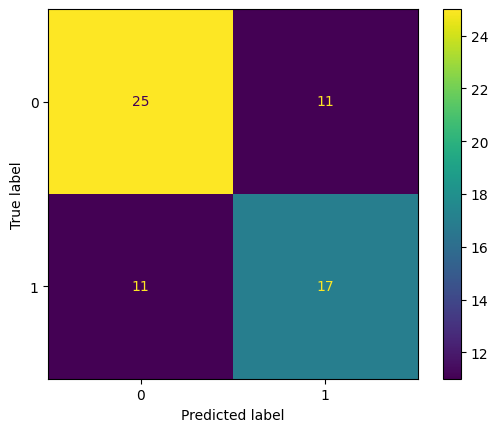

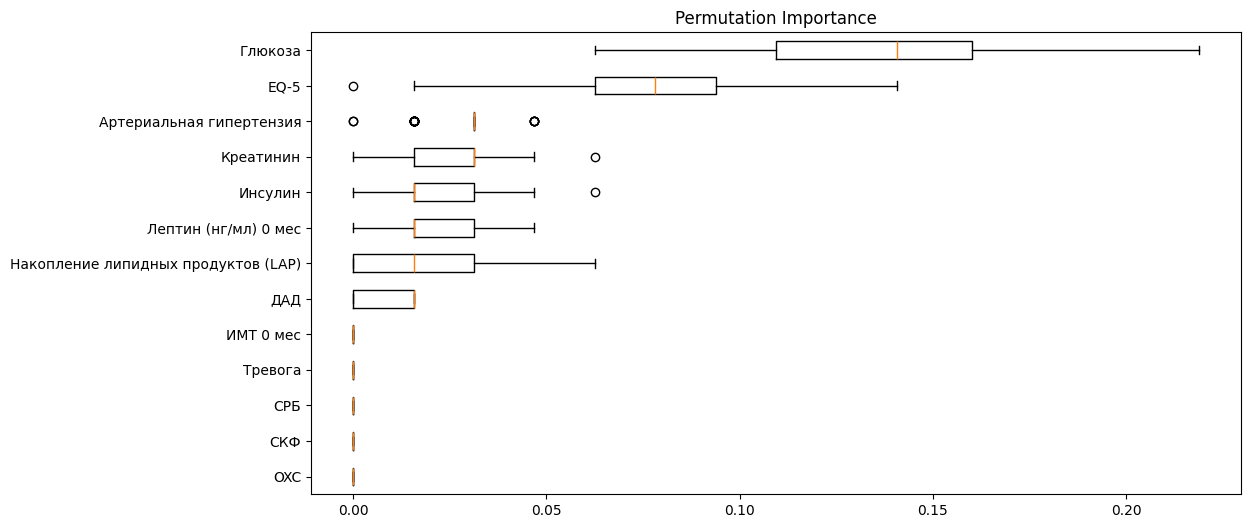

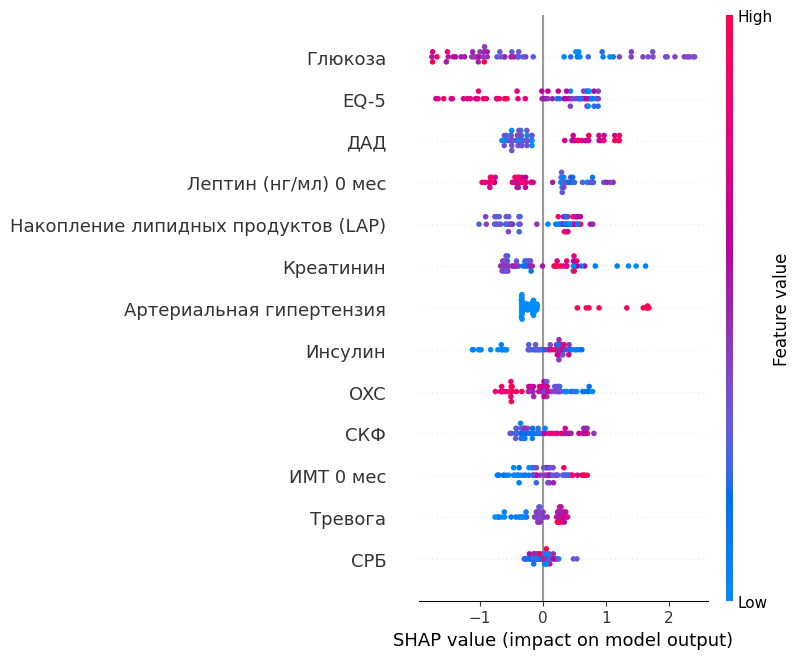

In [229]:
dt = Dataset(dataset_path="data/dataset_september.xlsx")
dt.preprocess(agroup_params_only=True)
p = ['Накопление липидных продуктов (LAP)',
 'Артериальная гипертензия',
 'ДАД',
 'Глюкоза',
 'Инсулин',
 'OXC',
 'Креатинин',
 'СКФ',
 'СРБ',
 'Лептин (нг/мл) 0 мес',
 'EQ-5',
 'Тревога',
 'ИМТ 0 мес']
X, y = dt.get_X_y("SIB", 5, params=p, target_type="A")
model, X, y_true, y_pred = classification_experiment(XGBClassifier(), X, y, use_pipeline=False)
experiment_logger(model, X, y_true, y_pred)

In [234]:
X_test, y_test = dt_test.get_X_y("SIB", 5, params=p, target_type="A")
model = XGBClassifier()
model.fit(X, y)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.25      0.12      0.17         8
           1       0.36      0.57      0.44         7

    accuracy                           0.33        15
   macro avg       0.31      0.35      0.31        15
weighted avg       0.30      0.33      0.30        15



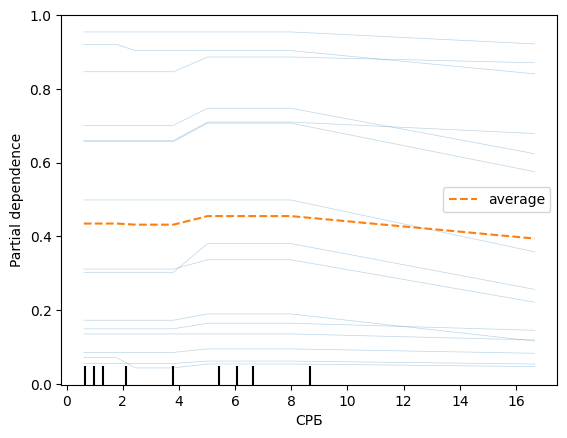

In [217]:
from sklearn.inspection import PartialDependenceDisplay
features = ['СРБ']
X_test, y_test = dt_test.get_X_y("SIB", 5, params=p)
display(PartialDependenceDisplay.from_estimator(model, X_test, features, kind='both'))

In [187]:
res.to_csv("02_importanceplusf1_F1_66.csv")

In [ ]:
t = []
sdpl_copy = sib_default_params_list.copy()
for i in range(5):
  sibstatsdf = recursively_delete_params("SIB", sdpl_copy)
  best_param = sibstatsdf[sibstatsdf["Count of parameters"]==1]["Set of params"].iloc[0][0]
  sdpl_copy.remove(best_param)
  t.append(best_param)
print(t)

['Инсулин', 'СРБ', 'HOMA-B', 'ЛПВП', 'индекс конусности ИК= ОТ(м)/0,109×√(рост(м)/вес (кг) 0 мес']




              precision    recall  f1-score   support

           0       0.70      0.77      0.73        43
           1       0.69      0.61      0.65        36

    accuracy                           0.70        79
   macro avg       0.69      0.69      0.69        79
weighted avg       0.70      0.70      0.69        79



,0,1
1,СРБ,0.2522
4,Лептин 1 час (нг/мл) 0 мес,0.1678
3,miR142 (ПЛАЗМА) 0 мес,0.1668
5,Инсулин,0.1492
0,"параксоназа мкг/мл (0,56-8,2) 0 мес",0.1363
2,Грелин 1 час (нг/мл) 0 мес.1,0.1278


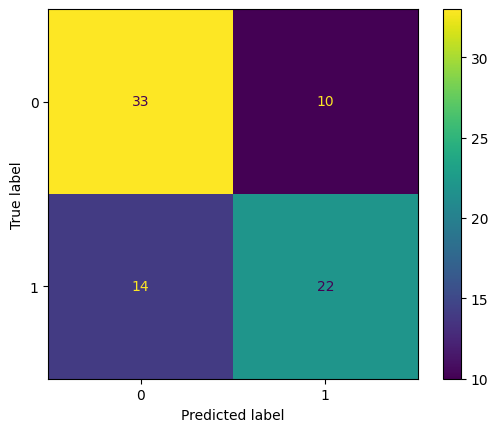

In [ ]:
model_sib, X, y_true, y_pred = classification_experiment(RandomForestClassifier(), medicine="SIB",
        params = ['параксоназа мкг/мл (0,56-8,2) 0 мес',
                  'СРБ',
                  'Грелин 1 час (нг/мл) 0 мес.1',
                  'miR142 (ПЛАЗМА) 0 мес',
                  'Лептин 1 час (нг/мл) 0 мес',
                  'Инсулин'], target_type="C")
statdf = pd.DataFrame(list(zip(model_sib[:-1].get_feature_names_out(), model_sib[-1].feature_importances_))).sort_values(by=1, ascending=False)
statdf = statdf[statdf[1]>0]
print("\n")
print(classification_report(y_true, y_pred))
display(statdf)
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

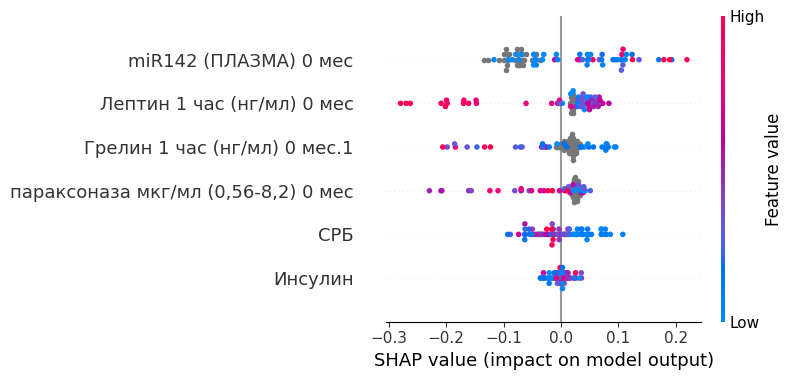

In [ ]:
explainer = shap.TreeExplainer(model[-1], X)
shap_values = explainer(X)
shap.summary_plot(shap_values[:, :, 1],X)

### SAX

In [ ]:
t = []
sdpl_copy = sax_default_params_list.copy()
for i in range(5):
  saxstatsdf = recursively_delete_params("SAX", sdpl_copy)
  best_param = saxstatsdf[saxstatsdf["Count of parameters"]==1]["Set of params"].iloc[0][0]
  sdpl_copy.remove(best_param)
  t.append(best_param)
print(t)


['ГПП 1 нг/мл 0 мес', 'Креатинин мкмоль/л (53-106) 0 мес', 'ТИМ справа ср, мм 0 мес', 'Е-селектин нг/мл 0 мес', 'CCL2 0 мес']




              precision    recall  f1-score   support

           0       0.80      0.67      0.73        12
           1       0.76      0.87      0.81        15

    accuracy                           0.78        27
   macro avg       0.78      0.77      0.77        27
weighted avg       0.78      0.78      0.77        27



,0,1
0,HOMA-B,0.2001
3,ЛПНП,0.1930
2,ГПП 1 нг/мл 0 мес,0.1841
5,ИМТ 0 мес,0.1693
4,Креатинин мкмоль/л (53-106) 0 мес,0.1387
1,Пульс,0.1148


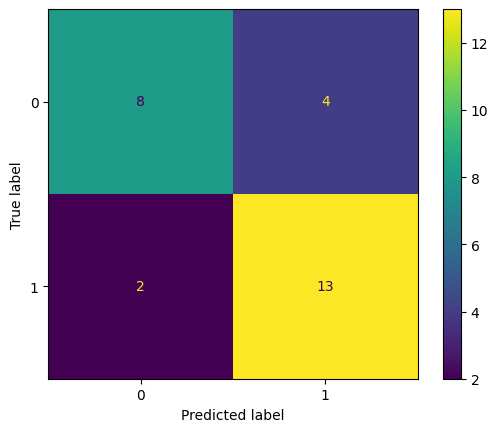

In [ ]:
model_sax, X, y_true, y_pred = classification_experiment(RandomForestClassifier(), medicine="SAX",
        params = ['ГПП 1 нг/мл 0 мес',
                  'Креатинин мкмоль/л (53-106) 0 мес',
                  'HOMA-B', 'ИМТ 0 мес', "Сартаны"], target_type="C")
statdf = pd.DataFrame(list(zip(model[:-1].get_feature_names_out(), model[-1].feature_importances_))).sort_values(by=1, ascending=False)
statdf = statdf[statdf[1]>0]
print("\n")
print(classification_report(y_true, y_pred))
display(statdf)
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

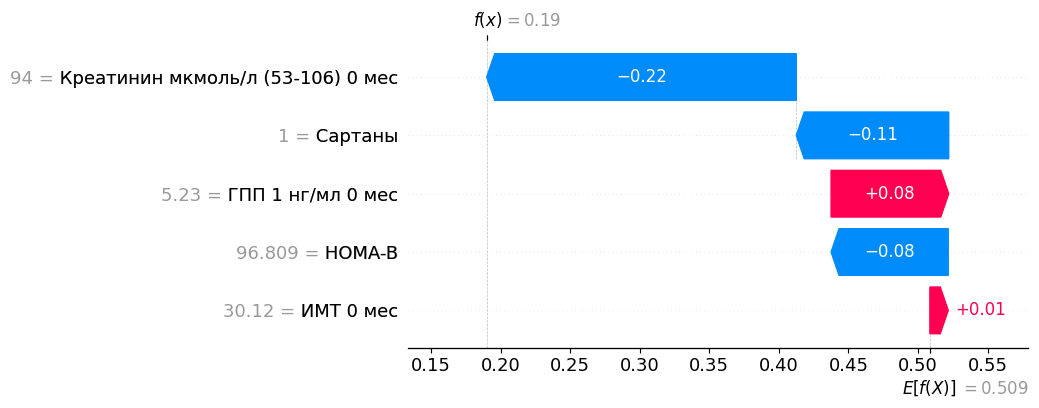

In [ ]:
shap.plots.waterfall(shap_values[7][:, 1])

## CatBoost

In [ ]:
m = catboost.CatBoostClassifier(learning_rate=0.001, iterations=10000)
st = []
dataset_x = some_transforms()
dataset_x = dataset_x[dataset_x["Лечение"]=="SIB"].drop(["Лечение"], 1)
X, y = dataset_x.drop(["% потери веса 3 мес", "% потери веса 6 мес"], 1), ((dataset_x["% потери веса 3 мес"]>=5)|(dataset_x["% потери веса 6 мес"]>=5)).astype(int)
# y = (y-y.min())/(y.max()-y.min())
# X.loc[:, cat_features] = X.loc[:, cat_features].astype(str)
X_train, X_test, y_train, y_test = train_test_split(X, y)
m.fit(X_train, y_train)
m.score(X_test, y_test)

In [ ]:
m = catboost.CatBoostClassifier(learning_rate=0.001, iterations=10000)
st = []
dataset_x = some_transforms()
dataset_x = dataset_x[dataset_x["Лечение"]=="SIB"].drop(["Лечение"], 1)
params = [
    'Адипонектин (мкг/мл) 0 мес',
    'Грелин 1 час (нг/мл) 0 мес.1',
    'miR142 (ПЛАЗМА) 0 мес',
    'Лептин 1 час (нг/мл) 0 мес',
    'ADIPOQ 0 мес',
    'Проколлаген 1 типа нг/мл (183-244) 0 мес'
]
X, y = dataset_x.drop(["% потери веса 3 мес", "% потери веса 6 мес"], 1)[params], ((dataset_x["% потери веса 3 мес"]>=5)|(dataset_x["% потери веса 6 мес"]>=5)).astype(int)
m.fit(X, y)

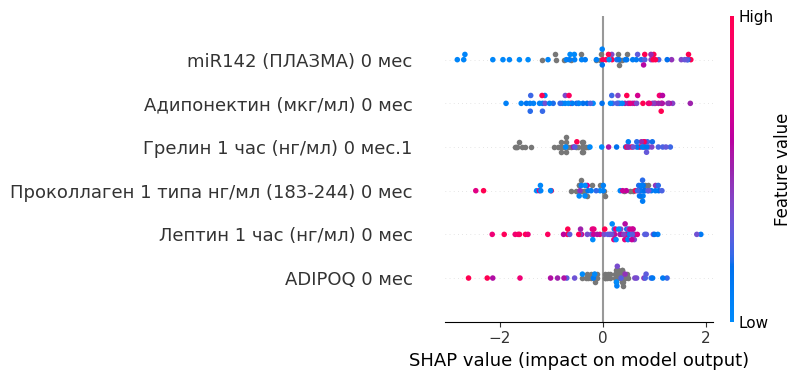

In [ ]:
# shap_values = m.get_feature_importance(Pool(X, y), type='ShapValues')
# expected_value = shap_values[0,-1]
# shap_values = shap_values[:,:-1]
# shap.summary_plot(shap_values, X)

## Тестирование модели на новых данных

In [ ]:
test_dataset_path = "data/dataset_almazov_november.xlsx"
if (not os.path.exists(test_dataset_path)):
  !gdown 1mYU2x0NhbIhmuCYAKPSP3Q9345sPlAC1 -O dataset_almazov_november.xlsx
test_dataset = pd.read_excel(test_dataset_path)
test_dataset = test_dataset.loc[125:, :]
test_dataset

,ID,"Пол 0 - М, 1 - Ж","Выполняли ли ПЭТ 0- нет, 1 - да","Наличие БЖТ исходно по ПЭТ 0 -нет, 1 - да","Наличие БЖТ через 6 мес по ПЭТ 0 -нет, 1 - да",Возраст,Рост,Вес 0 мес,Вес 3 мес,Вес 6 мес,...,Ограничительное (Диетическое) пищевое поведение В2.,Насколько голодным вы себя чувствуете? В2.,Насколько сытым вы себя чувствуете? В2.,Насколько сильно вы хотите есть? В2.,Сколько пищи вы могли бы сейчас съесть? В2.,Никотин В2.,Алкоголь В2.,EQ-5 В2.,Депрессия В1..1,Тревога В2.
125,SIB2-01,0,1,0.0000,NaN,25,180,134.0000,119.0000,126.0000,...,4.4000,5.0000,5.0000,2.0000,2.0000,NaN,NaN,80.0000,1.0000,4.0000
126,SIB2-02,1,1,0.0000,NaN,45,166,80.0000,76.0000,74.0000,...,2.7000,0.0000,10.0000,0.0000,0.0000,NaN,NaN,50.0000,4.0000,5.0000
127,SIB2-04,1,1,0.0000,0.0000,35,166,113.0000,106.0000,104.0000,...,2.4000,4.0000,4.0000,6.0000,3.0000,NaN,NaN,70.0000,7.0000,9.0000
128,SIB2-05,0,1,0.0000,0.0000,46,180,122.0000,120.0000,119.0000,...,2.0000,6.0000,4.0000,5.0000,4.0000,NaN,NaN,90.0000,10.0000,4.0000
129,SIB2-06,0,0,NaN,NaN,37,171,98.0000,91.0000,87.0000,...,3.7000,7.0000,5.0000,3.0000,4.0000,NaN,NaN,75.0000,4.0000,10.0000
130,SIB2-08,0,1,0.0000,0.0000,42,183,123.0000,120.0000,118.0000,...,3.5000,3.0000,8.0000,4.0000,4.0000,NaN,NaN,50.0000,3.0000,8.0000
131,SIB2-10,1,0,NaN,NaN,46,156,105.0000,101.0000,103.0000,...,2.4000,5.0000,5.0000,6.0000,7.0000,NaN,NaN,55.0000,11.0000,6.0000
132,SIB2-11,1,1,0.0000,0.0000,29,161,102.0000,100.0000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
133,SIB2-12,0,1,0.0000,0.0000,39,186,105.0000,102.0000,101.0000,...,2.6000,5.0000,5.0000,7.0000,3.0000,NaN,NaN,69.0000,5.0000,4.0000
134,SIB2-13,1,0,NaN,NaN,32,157,106.0000,95.0000,88.0000,...,2.6000,5.0000,5.0000,3.0000,4.0000,NaN,NaN,55.0000,8.0000,2.0000


## 3 bins

In [ ]:
def classification_experiment_multi(model, params, medicine="SIB", target_type="C"):
  dataset_x = some_transforms()
  dataset_x = dataset_x[dataset_x["Лечение"]==medicine].drop("Лечение", 1)
  if (target_type == "B"):
    dataset_x = dataset_x[~dataset_x["% потери веса 6 мес"].isna()]

  pipe = Pipeline([
    ("imputer", SimpleImputer()),
    ("regressor", model)
  ])

  cv_loo = LeaveOneOut()
  targetcol_3 = "% потери веса 3 мес"
  targetcol_6 = "% потери веса 6 мес"
  y_3 = dataset_x[targetcol_3]
  y_6 = dataset_x[targetcol_6]
  if (target_type=="A"):
    target = y_3.astype(int).reset_index(drop=True).to_numpy()
  if (target_type=="B"):
    target = y_6.astype(int).reset_index(drop=True).to_numpy()
  if (target_type=="C"):
    target = np.nanmax([y_3, y_6], axis=0)
  target = np.digitize(target, [-10, 5, 10])
  y = target
  X = dataset_x
  if params!=None:
    X = dataset_x[params]
  X = X.loc[:, ~X.isna().all()]
  X = X.reset_index(drop=True)
  for j in [targetcol_3, targetcol_6]:
    if (j in X.columns):
      X = X.drop(j, axis=1)
  y_pred = []
  y_true = []
  for idx, (train_index, test_index) in enumerate(cv_loo.split(X)):
    X_train, X_test, y_train, y_test = X.iloc[train_index, :], \
                                      X.iloc[test_index, :], \
                                      y[train_index], \
                                      y[test_index]
    try:
      pipe.fit(X_train, y_train)
    except:
      raise Exception(str((X_train, y_train)))
    y_pred.append(pipe.predict(X_test))
    y_true.append(y_test[0])
  y_pred = np.array(y_pred).squeeze().tolist()
  y_true = np.array(y_true).squeeze().tolist()
  return pipe, X, y_true, y_pred

In [ ]:
def recursively_delete_params_multi(medicine, set_of_params):
  params_to_eliminate = set_of_params.copy()
  stats = []
  while len(params_to_eliminate)!=0:
    try:
      model, X, y_true, y_pred = classification_experiment_multi(DecisionTreeClassifier(),
                                                                params=params_to_eliminate,
                                                                medicine=medicine,
                                                                target_type="C")
    except:
      break
    statdf = pd.DataFrame(list(zip(model[:-1].get_feature_names_out(), model[-1].feature_importances_))).sort_values(by=1, ascending=False)
    statdf = statdf[statdf[1]>0]
    macro_f1 = classification_report(y_true, y_pred, output_dict=True)["macro avg"]["f1-score"]
    stats.append([params_to_eliminate.copy(), macro_f1, len(params_to_eliminate.copy())])
    param_to_remove = statdf.iloc[-1, 0]
    params_to_eliminate.remove(param_to_remove)
    # print("Progress: ", len(set_of_params) - len(params_to_eliminate), " / ", len(set_of_params), "F score ", macro_f1)
  dfstats = pd.DataFrame(stats, columns=["Set of params", "F1", "Count of parameters"])
  dfstats = dfstats.sort_values(by = "F1", ascending=False)
  return dfstats

In [ ]:
t = []
sdpl_copy = sib_default_params_list.copy()
for i in range(5):
  sibstatsdf = recursively_delete_params_multi("SIB", sdpl_copy)
  best_param = sibstatsdf[sibstatsdf["Count of parameters"]==1]["Set of params"].iloc[0][0]
  sdpl_copy.remove(best_param)
  t.append(best_param)
print(t)

['HOMA-B', 'Глюкоза', 'СРБ', 'ЛПНП', 'Лептин/Адипонектин 0 мес']




              precision    recall  f1-score   support

           1       0.54      0.67      0.59        33
           2       0.35      0.32      0.33        28
           3       0.25      0.17      0.20        18

    accuracy                           0.43        79
   macro avg       0.38      0.38      0.38        79
weighted avg       0.40      0.43      0.41        79



,0,1
1,СРБ,0.2010
5,Инсулин,0.1886
3,miR142 (ПЛАЗМА) 0 мес,0.1701
4,Лептин 1 час (нг/мл) 0 мес,0.1688
0,"параксоназа мкг/мл (0,56-8,2) 0 мес",0.1551
2,Грелин 1 час (нг/мл) 0 мес.1,0.1164


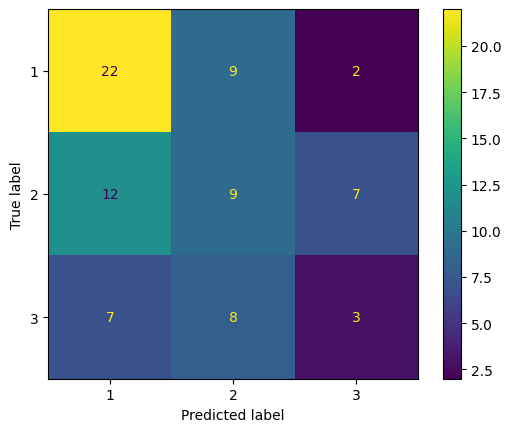

In [ ]:
# model, X, y_true, y_pred = classification_experiment_multi(RandomForestClassifier(), medicine="SIB", params = ['СРБ', 'ЛПНП', 'Лептин/Адипонектин 0 мес', 'Глюкоза', 'OXC'], target_type="C")
model, X, y_true, y_pred = classification_experiment_multi(RandomForestClassifier(), medicine="SIB", params = ['параксоназа мкг/мл (0,56-8,2) 0 мес',
                  'СРБ',
                  'Грелин 1 час (нг/мл) 0 мес.1',
                  'miR142 (ПЛАЗМА) 0 мес',
                  'Лептин 1 час (нг/мл) 0 мес',
                  'Инсулин'], target_type="C")
statdf = pd.DataFrame(list(zip(model[:-1].get_feature_names_out(), model[-1].feature_importances_))).sort_values(by=1, ascending=False)
statdf = statdf[statdf[1]>0]
print("\n")
print(classification_report(y_true, y_pred))
display(statdf)
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

Text(0.5, 1.0, 'Permutation Importance')

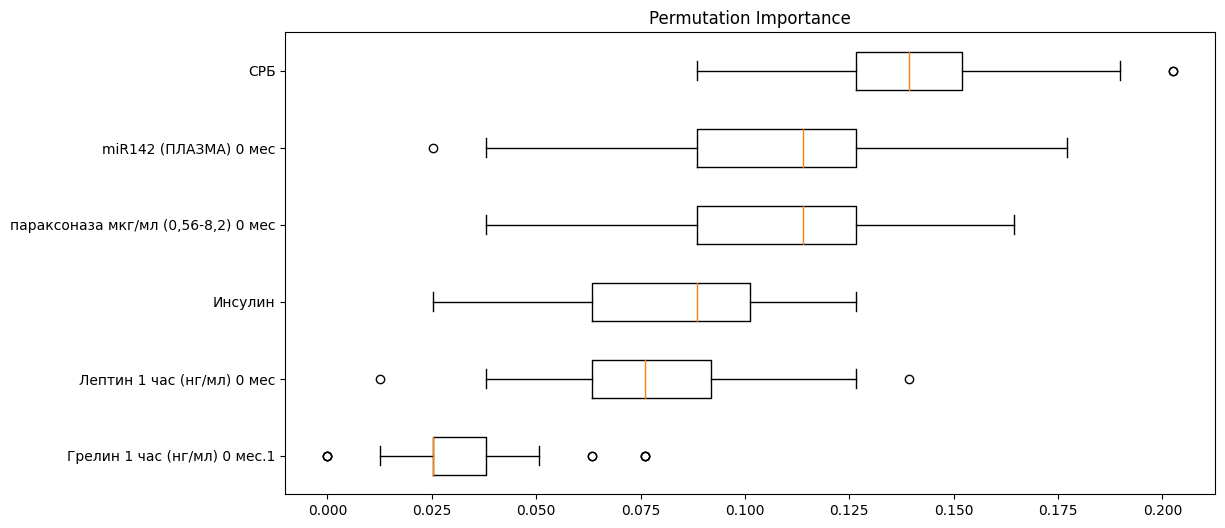

In [ ]:
feature_importance =  model[-1].feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5

fig = plt.figure(figsize=(12, 6))
result = permutation_importance(
    model, X, y_true, n_repeats=100
)
sorted_idx = result.importances_mean.argsort()
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=model[:-1].get_feature_names_out()[sorted_idx],
)
plt.title("Permutation Importance")

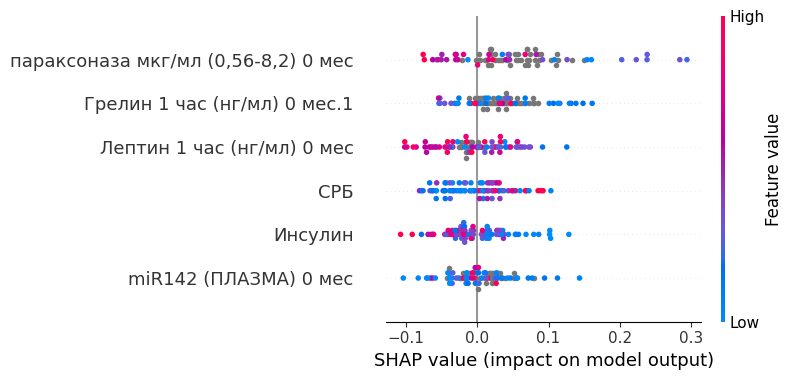

In [ ]:
explainer = shap.TreeExplainer(model[-1])
shap_values = explainer(X)
shap.summary_plot(shap_values[:, :, 1],X)

SAX

In [ ]:
t = []
sdpl_copy = sax_default_params_list.copy()
for i in range(3):
  sibstatsdf = recursively_delete_params_multi("SAX", sdpl_copy)
  best_param = sibstatsdf[sibstatsdf["Count of parameters"]==1]["Set of params"].iloc[0][0]
  sdpl_copy.remove(best_param)
  t.append(best_param)
print(t)

['HOMA-B', 'ГПП 1 нг/мл 0 мес', 'Креатинин мкмоль/л (53-106) 0 мес']




              precision    recall  f1-score   support

           1       0.71      0.83      0.77        12
           2       0.57      0.57      0.57         7
           3       0.67      0.50      0.57         8

    accuracy                           0.67        27
   macro avg       0.65      0.63      0.64        27
weighted avg       0.66      0.67      0.66        27



,0,1
0,HOMA-B,0.2001
3,ЛПНП,0.1930
2,ГПП 1 нг/мл 0 мес,0.1841
5,ИМТ 0 мес,0.1693
4,Креатинин мкмоль/л (53-106) 0 мес,0.1387
1,Пульс,0.1148


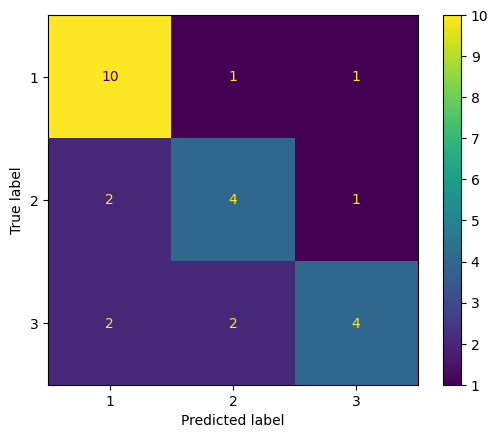

In [ ]:
model, X, y_true, y_pred = classification_experiment_multi(RandomForestClassifier(), medicine="SAX",
        params = ['HOMA-B', 'Пульс', 'ГПП 1 нг/мл 0 мес', 'ЛПНП', 'Креатинин мкмоль/л (53-106) 0 мес', 'ИМТ 0 мес'], target_type="C")
statdf = pd.DataFrame(list(zip(model[:-1].get_feature_names_out(), model[-1].feature_importances_))).sort_values(by=1, ascending=False)
statdf = statdf[statdf[1]>0]
print("\n")
print(classification_report(y_true, y_pred))
display(statdf)
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

Text(0.5, 1.0, 'Permutation Importance')

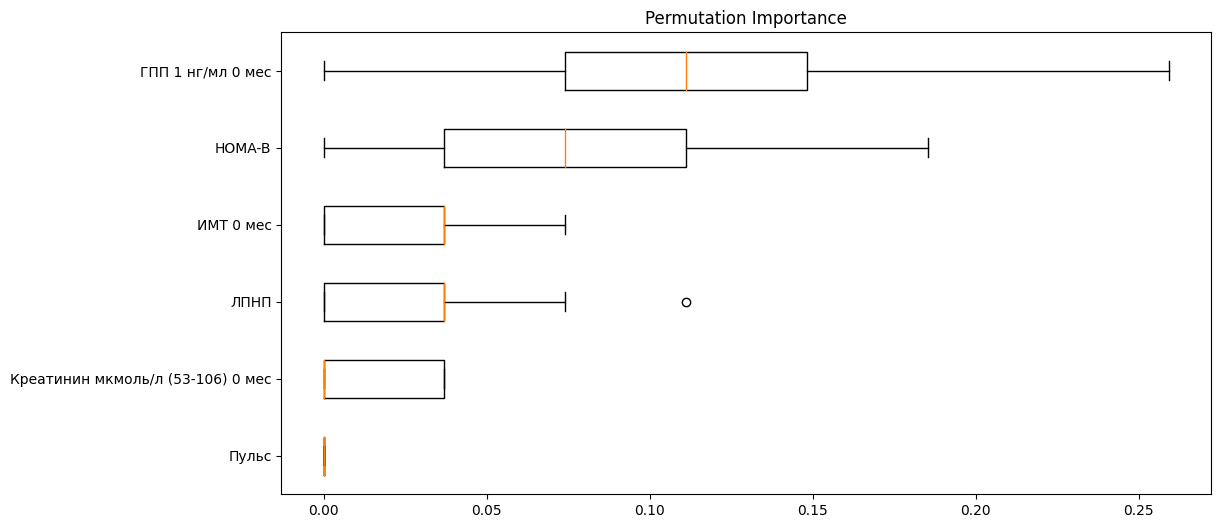

In [ ]:
feature_importance =  model[-1].feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5

fig = plt.figure(figsize=(12, 6))
result = permutation_importance(
    model, X, y_true, n_repeats=100
)
sorted_idx = result.importances_mean.argsort()
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=model[:-1].get_feature_names_out()[sorted_idx],
)
plt.title("Permutation Importance")

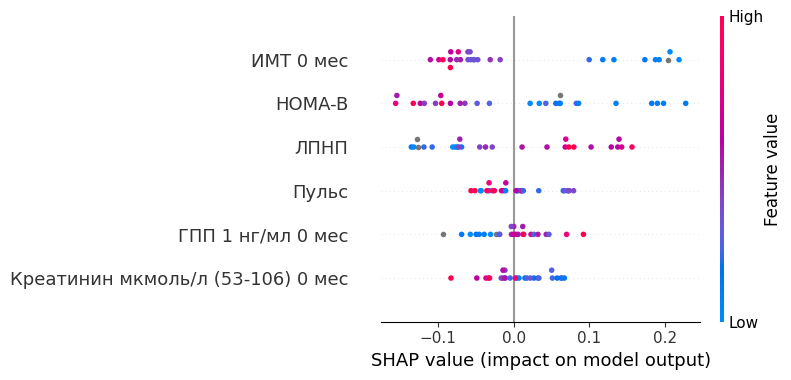

In [ ]:
explainer = shap.TreeExplainer(model[-1])
shap_values = explainer(X)
shap.summary_plot(shap_values[:, :, 1],X)

## Fedot

In [ ]:
!pip install fedot

In [ ]:
import logging
import fedot

In [ ]:
default_predictors = list(filter(lambda x: x not in targets, agroup_parameters)) # список предикторов
def validate_model_fedot(pipe_super, dataset, target="% потери веса 3 мес"):
  target = "% потери веса 3 мес"
  np.random.seed(42)

  # cv
  cv_loo = LeaveOneOut()
  X = dataset.drop(columns=target)
  y = dataset[target]
  y_pred = []
  for idx, (train_index, test_index) in enumerate(cv_loo.split(dataset)):

    X_train, X_test, y_train, y_test = X.iloc[train_index, :], \
                                      X.iloc[test_index, :], \
                                      y[train_index], \
                                      y[test_index]
    data_fedot_train =
    pipe_super.unfit()
    pipe_super.fit(X_train, y_train)
    y_pred.append(pipe_super.predict(X_test))

  # intervals
  y, y_pred = np.array(y).squeeze(), np.array(y_pred).squeeze()
  mse = (y - y_pred) ** 2
  mae = np.abs(y - y_pred)
  r2 = ((y-y_pred)**2)/((y-np.mean(y))**2)
  print(r2)
  l_mse, r_mse = norm.interval(alpha=0.95, loc=np.mean(mse), scale=np.std(mse))
  l_mae, r_mae = norm.interval(alpha=0.95, loc=np.mean(mae), scale=np.std(mae))
  l_r2, r_r2 = norm.interval(alpha=0.95, loc=np.mean(r2), scale=np.std(r2))

  # binary metrics
  y_label = (y>5).astype(np.int64).squeeze()
  y_pred_label = (y_pred>5).astype(np.int64).squeeze()
  try:
    model_name = pipe_super["regressor"].__class__.__name__
  except:
    try:
      model_name = str(pipe_super)
    except:
      model_name = "Undefined"
  return {
      "model": model_name,
      "date": datetime.now().strftime("%H:%M %d/%m/%y"),
      "r2": r2_score(y, y_pred),
      "interval_explained_variance": (l_r2, r_r2),
      "mae": mean_absolute_error(y, y_pred),
      "interval_mae": (round(max(0, l_mae), 2), round(r_mae, 2)),
      "rmse": mean_squared_error(y, y_pred, squared=False),
      "interval_rmse": (round(max(0, np.sqrt(l_mse)), 2), round(np.sqrt(r_mse), 2)),
      "accuracy": accuracy_score(y_label, y_pred_label),
      "precision": precision_score(y_label, y_pred_label),
      "recall": precision_score(y_label, y_pred_label),
      "rocAUC": roc_auc_score(y_label, y_pred_label),
      "f1": f1_score(y_label, y_pred_label)
  }

In [ ]:
dataset_x = some_transforms()
dataset_x = dataset_x[dataset_x["Лечение"]=='SIB'].drop("Лечение", 1)
targetcol_3 = "% потери веса 3 мес"
targetcol_6 = "% потери веса 6 мес"
y_3 = dataset_x[targetcol_3]
y_6 = dataset_x[targetcol_6]
target = (np.nanmax([y_3, y_6], axis=0).round()>=treshold).astype(int)
y = target

X = dataset_x.drop([targetcol_3, targetcol_6], axis=1)
X = X.loc[:, ~X.isna().all()]
X = X.reset_index(drop=True)


NameError: ignored

In [ ]:
fedot_solver = Fedot(problem="regression", timeout=1, preset='fast_train', n_jobs=-1, logging_level=logging.FATAL)
result = fedot_solver.fit(X, y)

NameError: ignored

In [ ]:
validate_model_fedot(result, dataset, target="% потери веса 3 мес")

In [ ]:
if fedot_solver.history and fedot_solver.history.generations:
    print(fedot_solver.history.get_leaderboard())

fedot_solver.current_pipeline.show()

In [ ]:
X_test = X.iloc[:6, :]
y_test = y[:6]
X_test.drop(columns=[target], inplace=True)
X_test

In [ ]:
fedot_solver.predict(X_test)
metrics = fedot_solver.get_metrics()

In [ ]:
fedot_solver.predict(X_test)

In [ ]:
X_test[target]

In [ ]:
metrics

## Economical efficancy

In [ ]:
target_type="C"
dataset_x = some_transforms()
dataset_x = dataset_x[dataset_x["Лечение"].isin(["SIB", "SAX"])]
treatment = dataset_x["Лечение"]
dataset_x = dataset_x.drop("Лечение", 1)

pipe_sib = Pipeline([
  ("imputer", SimpleImputer()),
  ("regressor", RandomForestClassifier())
])

pipe_sax = Pipeline([
  ("imputer", SimpleImputer()),
  ("regressor", RandomForestClassifier())
])

cv_loo = LeaveOneOut()
targetcol_3 = "% потери веса 3 мес"
targetcol_6 = "% потери веса 6 мес"
y_3 = dataset_x[targetcol_3]
y_6 = dataset_x[targetcol_6]
treshold = 5
target = (np.nanmax([y_3, y_6], axis=0).astype(int)>treshold).astype(int)
y = target
X = dataset_x
sib_params = ['параксоназа мкг/мл (0,56-8,2) 0 мес',
                  'СРБ',
                  'Грелин 1 час (нг/мл) 0 мес.1',
                  'miR142 (ПЛАЗМА) 0 мес',
                  'Лептин 1 час (нг/мл) 0 мес',
                  'Инсулин']

sax_params = ['ГПП 1 нг/мл 0 мес',
                  'Креатинин мкмоль/л (53-106) 0 мес',
                  'HOMA-B', 'ИМТ 0 мес', "Сартаны"]

X = X.loc[:, ~X.isna().all()]
X = X.reset_index(drop=True)
for j in [targetcol_3, targetcol_6]:
  if (j in X.columns):
    X = X.drop(j, axis=1)
y_pred = []
y_true = []
print(X.shape, y.shape)
for idx, (train_index, test_index) in enumerate(cv_loo.split(X)):
  X_train, X_test, y_train, y_test = X.iloc[train_index, :], \
                                    X.iloc[test_index, :], \
                                    y[train_index], \
                                    y[test_index]
  print()
  patient_treatment = treatment[idx]
  if (patient_treatment == "SIB"):
    model = pipe_sib
  else:
    model = pipe_sax
  model.fit(X_train, y_train)
  y_pred.append(pipe.predict(X_test))
  y_true.append(y_test[0])
  break
y_pred = np.array(y_pred).squeeze()

(106, 169) (106,)



In [ ]:
def sppr_test(idx, X_input, y_input, treatment):
  X = X_input.copy()
  y = y_input.copy()
  test_sample = X.loc[idx]
  test_medicine = treatment.values[idx]
  test_success = y[idx]
  treatment_tmp = treatment.values.copy()

  sib_params = ['параксоназа мкг/мл (0,56-8,2) 0 мес',
                    'СРБ',
                    'Грелин 1 час (нг/мл) 0 мес.1',
                    'miR142 (ПЛАЗМА) 0 мес',
                    'Лептин 1 час (нг/мл) 0 мес',
                    'Инсулин']

  sax_params = ['ГПП 1 нг/мл 0 мес',
                    'Креатинин мкмоль/л (53-106) 0 мес',
                    'HOMA-B', 'ИМТ 0 мес', "Сартаны"]

  tmp_X = X.drop(idx)
  tmp_y = np.delete(y, idx, 0)
  treatment_tmp = np.delete(treatment_tmp, idx, 0)

  model_sib_tmp = Pipeline([
    ("imputer", SimpleImputer()),
    ("regressor", RandomForestClassifier())
  ])
  model_sax_tmp = Pipeline([
    ("imputer", SimpleImputer()),
    ("regressor", RandomForestClassifier())
  ])

  model_sib_tmp.fit(tmp_X.loc[treatment_tmp=="SIB", sib_params], tmp_y[treatment_tmp=="SIB"])
  model_sax_tmp.fit(tmp_X.loc[treatment_tmp=="SAX", sax_params], tmp_y[treatment_tmp=="SAX"])
  sib_solution = model_sib_tmp.predict([test_sample[sib_params]])[0]
  sax_solution = model_sax_tmp.predict([test_sample[sax_params]])[0]
  return test_medicine, test_success, sib_solution, sax_solution

stats = []
for i in range(X.shape[0]):
  stats.append(sppr_test(i, X, y, treatment))

df = pd.DataFrame(stats, columns=["Врач", "Модель - Сибутрамин", "Модель - Саксенда", "Успех"])
df

,Врач,Модель - Сибутрамин,Модель - Саксенда,Успех
0,SIB,0,0,1
1,SIB,1,1,0
2,SIB,1,1,1
3,SIB,1,1,1
4,SIB,0,1,1
...,...,...,...,...
101,SIB,0,0,1
102,SIB,0,0,1
103,SIB,1,1,1
104,SIB,0,1,1


In [ ]:
df[(df.iloc[:, 0]=="SIB") & (df.iloc[:, 1]==0) & (df.iloc[:, 2]==1)].groupby("Успех").count()

,Врач,Модель - Сибутрамин,Модель - Саксенда
Успех,,,
0,3,3,3
1,8,8,8


In [ ]:
df[(df.iloc[:, 0]=="SAX")].groupby("Успех").count()

,Врач,Модель - Сибутрамин,Модель - Саксенда
Успех,,,
0,10,10,10
1,17,17,17


In [ ]:
df[(df.iloc[:, 0]=="SIB")].groupby("Успех").count()

,Врач,Модель - Сибутрамин,Модель - Саксенда
Успех,,,
0,14,14,14
1,65,65,65


In [ ]:
df[(df.iloc[:, 0]=="SAX") & ((df.iloc[:, 1]==1) & (df.iloc[:, 2]==0))].groupby("Успех").count()

,Врач,Модель - Сибутрамин,Модель - Саксенда
Успех,,,
0,2,2,2
1,6,6,6


In [ ]:
df[(df.iloc[:, 0]=="SAX") & ((df.iloc[:, 1]==0) & (df.iloc[:, 2]==1))].groupby("Успех").count()

,Врач,Модель - Сибутрамин,Модель - Саксенда
Успех,,,
0,1,1,1
1,2,2,2


In [ ]:
df[(df.iloc[:, 0]=="SIB") & (df.iloc[:, 1]==1) & (df.iloc[:, 2]==0)].groupby("Успех").count()

,Врач,Модель - Сибутрамин,Модель - Саксенда
Успех,,,
0,3,3,3
1,11,11,11
